# Dependence analysis between fighting frequency and result/outcome of fights using descriptive statistics.

## Segment 1: *Introduction*

The main objective of the analysis is to establish whether there is any significant correlation between the length of time intervals in MMA fights and the outcome/result of these bouts, using descriptive statistics. **The term result in this analysis is defined as** the percentage ratio between the amount of wins and the total amount of wins and losses for a certain fighter (for the prupose of this analysis, **fights that have ended with a draw, or a no-contest, will not be taken into account**).

The threshold of statistical significance in the analysis is defined as **10 percentage points**. That being said, the analysis will not exclude dependencies under that threshold, provided that there is enough collected data to state a rational hypothesis.

The subject of the analysis covers all **professional** fights recorded by www.sherdog.com.

In order to investigate potential dependencies, which are distinctive for certain groups, the analysis will consider the following categories:

* current UFC roster
* current UFC roster, with regards to bouts that took place exclusively inside the UFC
* current UFC roster, with regards to bouts that took place exclusively inside the UFC (gender distinction)
* current UFC roster, with regards to bouts that took place exclusively inside the UFC (weight class distinction)
* all fights recorded in the Sherdog database, with regards to fighters, that had lost their previous fight via KO/TKO
* current UFC roster, with regards to fighters that lost their previous fight via KO/TKO
* all fights recorded in the Sherdog database, with regards to fighters that have had 5-round bouts previously
* current UFC roster, with regards to fighters that have had 5-round bouts previously

Additionally, the analysis will introduce some interesting facts regarding the previously mentioned data set:

* interval with the highest number of observations for each weight class inside the UFC
* dependence between the result of all fights recorded in Sherdog's database and the UFC roster
* percentage of fighters from the current UFC roster that won their MMA debut
* which MMA fighter had the lengthiest discontinuity between fights and how many days it took

***please note that all data used in the analysis was collected on the 10th of November 2019.***


## Segment 2: *Loading, cleaning and analyzing Sherdog's database*

In [458]:
# Importing modules
import pandas as pd
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt
import os
from datetime import datetime
from dateutil.parser import parse
from datetime import timedelta
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

In [460]:
# Loading Sherdog's database.
sherdog_data = pd.read_csv('sherdog_final.csv', header=0, sep=";", engine='python')
sherdog_data[0:10]

,Fighter,Opponent,Result,Event,Event_date,Method,Referee,Round,Time;
0,Tony Galindo,Tony Lopez,loss,KOTC 49 Soboba,Mar / 20 / 2005,KO (Punches),NaN,1,3:24;
1,Tony Galindo,Joey Villasenor,loss,KOTC 21 Invasion,Feb / 21 / 2003,TKO (Corner Stoppage),Larry Landless,1,5:00;
2,Tony Galindo,Brian Sleeman,loss,GC 6 Caged Beasts,Sep / 09 / 2001,TKO (Corner Stoppage),Larry Landless,2,3:10;
3,Tony Galindo,Reggie Cardiel,win,KOTC 9 Showtime,Jun / 23 / 2001,Decision,NaN,2,5:00;
4,Tony Galindo,Reggie Cardiel,draw,KOTC 7 Wet and Wild,Feb / 24 / 2001,Draw,NaN,2,5:00;
5,Tony Galindo,Brian Hawkins,win,KOTC 6 Road Warriors,Nov / 29 / 2000,TKO (Punches),NaN,1,1:30;
6,Tony Galindo,Kurt Rojo,win,KOTC 4 Gladiators,Jun / 24 / 2000,KO (Punch),NaN,1,0:07;
7,Kurt Rojo,Phillip Miller,loss,GC 1 Gladiator Challenge 1,Dec / 09 / 2000,Decision,NaN,3,5:00;
8,Kurt Rojo,Tony Galindo,loss,KOTC 4 Gladiators,Jun / 24 / 2000,KO (Punch),NaN,1,0:07;
9,Brian Hawkins,James Lee,loss,KOTC Drop Zone,Mar / 18 / 2006,Submission (Heel Hook),NaN,1,0:24;


In [461]:
# Creating data frame copy reduced to essential columns.
sherdog_selected_data = sherdog_data[['Fighter', 'Result', 'Event_date']].copy()

In [462]:
sherdog_selected_data[0:10]

,Fighter,Result,Event_date
0,Tony Galindo,loss,Mar / 20 / 2005
1,Tony Galindo,loss,Feb / 21 / 2003
2,Tony Galindo,loss,Sep / 09 / 2001
3,Tony Galindo,win,Jun / 23 / 2001
4,Tony Galindo,draw,Feb / 24 / 2001
5,Tony Galindo,win,Nov / 29 / 2000
6,Tony Galindo,win,Jun / 24 / 2000
7,Kurt Rojo,loss,Dec / 09 / 2000
8,Kurt Rojo,loss,Jun / 24 / 2000
9,Brian Hawkins,loss,Mar / 18 / 2006


In [463]:
# Checking for missing values in a 'Event_date' column.
sherdog_selected_data[sherdog_selected_data['Event_date'].isna()]

,Fighter,Result,Event_date


In [464]:
# Converting strings to datetime values in the 'Event_date' column.
converted_dates = []
for i in range(len(sherdog_selected_data['Event_date'])):
    converted_dates.append(parse(sherdog_selected_data['Event_date'][i]))

In [465]:
# Assigning the converted data to the 'Event_date' column.
sherdog_selected_data['Event_date'] = converted_dates

In [466]:
sherdog_selected_data[0:10]

,Fighter,Result,Event_date
0,Tony Galindo,loss,2005-03-20
1,Tony Galindo,loss,2003-02-21
2,Tony Galindo,loss,2001-09-09
3,Tony Galindo,win,2001-06-23
4,Tony Galindo,draw,2001-02-24
5,Tony Galindo,win,2000-11-29
6,Tony Galindo,win,2000-06-24
7,Kurt Rojo,loss,2000-12-09
8,Kurt Rojo,loss,2000-06-24
9,Brian Hawkins,loss,2006-03-18


In [467]:
# Creating time intervals between fights for each fighter.
intervals = []
for i in range(len(sherdog_selected_data['Fighter']) - 1):
    if sherdog_selected_data['Fighter'][i] == sherdog_selected_data['Fighter'][i + 1]:
        intervals.append(sherdog_selected_data['Event_date'][i] - sherdog_selected_data['Event_date'][i + 1])
        intervals[i] = intervals[i].days
    else:
        intervals.append(0)
intervals.append(0)   # appending last interval (0) to the last fight in database.

In [468]:
# Creating and assigning time intervals to a new column.
sherdog_selected_data['Time_interval'] = intervals

In [469]:
# Data validation - all intervals should be greater, or equal to 0.
'''One record is corrupted due to a missing debut date in the Sherdog's database. 
The record will be omitted in remaining part of the analysis.'''
sherdog_selected_data[sherdog_selected_data['Time_interval'] < 0]

,Fighter,Result,Event_date,Time_interval
25590,Paulo de Jesus,loss,1995-07-05,-2340


In [470]:
# Removing previously mentioned record from database.
sherdog_selected_data = sherdog_selected_data.drop(sherdog_selected_data.index[25590])

In [471]:
# Taking a closer look at distribution parameters.
sherdog_selected_data.describe()

,Time_interval
count,504347.000000
mean,162.577224
std,293.667982
min,0.000000
25%,0.000000
50%,77.000000
75%,189.000000
max,8730.000000


In [472]:
# Assigning a mean, median and mode to variables.
sher_mean = sherdog_selected_data['Time_interval'].mean()
sher_med = sherdog_selected_data['Time_interval'].median()
# Slightly moving mode for the sake of visualization.
sher_mode = sherdog_selected_data['Time_interval'].mode().get_values() + 5                           

In [473]:
# Counting number of values in the 'Time_interval' column.
len(sherdog_selected_data['Time_interval'].value_counts())

2947

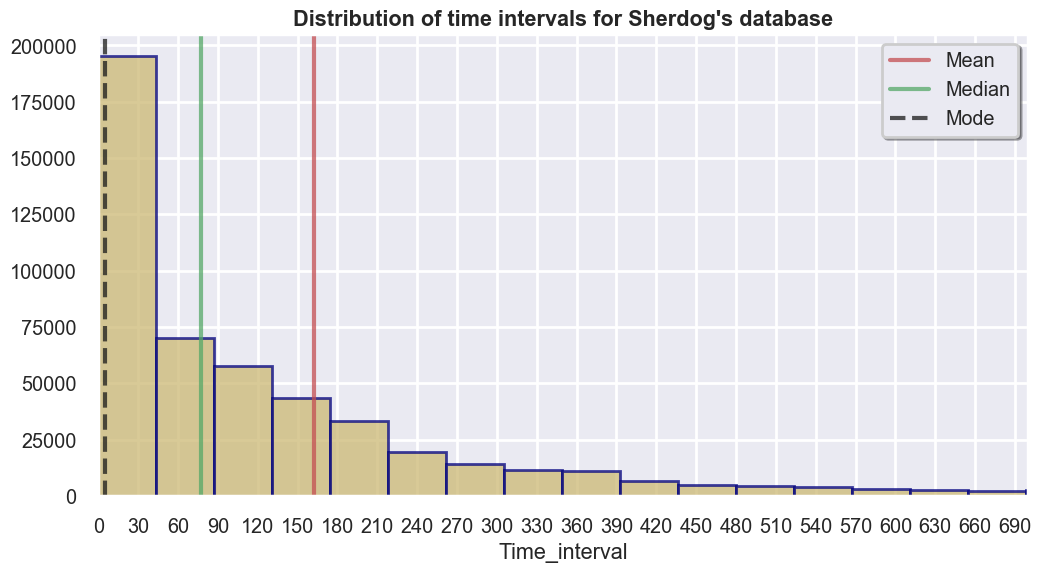

In [474]:
# Plotting data distribution.
plt.rcdefaults()
    
plt.figure(figsize=(12,6), dpi= 100)
sns.set(style='darkgrid')
sns.set_context('poster', font_scale = 0.65)
ax = sns.distplot(sherdog_selected_data['Time_interval'], kde=False, color='y', bins=200,
                  hist_kws=dict(edgecolor='navy', alpha=0.75))
ax.set_xlim(0, 700)
ax.xaxis.set_major_locator(plt.MaxNLocator(25))

ax.axvline(sher_mean, color='r', linestyle='solid', alpha=0.75)
ax.axvline(sher_med, color='g', linestyle='solid', alpha=0.75)
ax.axvline(sher_mode, color='k', linestyle='dashed', alpha=0.75)
plt.title("Distribution of time intervals for Sherdog's database", fontweight='bold')
plt.legend({'Mean':sher_mean, 'Median':sher_med, 'Mode':sher_mode}, frameon=True, shadow=True)
plt.show()

In [475]:
# Showing 15 most frequent time intervals in the database.
sherdog_selected_data['Time_interval'].value_counts().nlargest(15)

0      138034
63       6804
56       6385
91       6185
70       6066
28       6003
35       5913
84       5789
49       5756
77       5713
42       5529
98       5367
105      5138
119      5025
21       4858
Name: Time_interval, dtype: int64

In [476]:
sherdog_selected_data[0:10]

,Fighter,Result,Event_date,Time_interval
0,Tony Galindo,loss,2005-03-20,758
1,Tony Galindo,loss,2003-02-21,530
2,Tony Galindo,loss,2001-09-09,78
3,Tony Galindo,win,2001-06-23,119
4,Tony Galindo,draw,2001-02-24,87
5,Tony Galindo,win,2000-11-29,158
6,Tony Galindo,win,2000-06-24,0
7,Kurt Rojo,loss,2000-12-09,168
8,Kurt Rojo,loss,2000-06-24,0
9,Brian Hawkins,loss,2006-03-18,1121


We can see that the distribution is positively skewed. We are dealing with ***2947 different time intervals***. Given the distribution skewness, the amount of different time intervals, the fact that we are working with a whole population and the practical necessity to categorize data in a readable and clear manner, I have decided to create buckets (categories) which can be used in further analysis to describe data:

* Bucket No. 1 - Debut/on the same day *(0 days)*
* Bucket No. 2 - Very often *(1-90 days)*
* Bucket No. 3 - Often *(91-120 days)*
* Bucket No. 4 - Moderately often *(121-182 days)*
* Bucket No. 5 - Infrequently *(183-365 days)*
* Bucket No. 6 - Very rarely *(366-728 days)*
* Bucket No. 7 - Returning after a very long layoff *(above 729 days)*

**Bucket No. 1** contains debuts and bouts that took place on the same day (in most cases as a part of one-night tournaments).

**Bucket No. 2** represents frequency comparable to four bouts per year (relatively rare thing, even if in respect to the amount of events that the UFC is producing).

**Bucket No. 3** represents frequency comparable to three bouts per year (a bit more likely to happen in the UFC than four bouts per year, although still quite rare).

**Bucket No. 4** represents frequency comparable to two bouts per year, which is usually the minimal amount of bouts per year from the fighters' perspective. It also happens to meet the UFC's demand, given that in 2019 the UFC have scheduled 43 events. Each event usually contains 11-12 bouts which gives us approximately a demand for 1032 fighters per calendar year. The UFC roster counts 698 athletes (*based on data from www.ufc.com on November 12, 2019*), so there is a good reason to consider this frequency to be "the golden standard".

**Bucket No. 5** represents frequency comparable to one bout per year. Based on the data mentioned above, we can consider that this frequency is also quite common inside the UFC, although it might not be the case for fighters outside the UFC, especially in the early stages of career development.

**Bucket No. 6** represents frequency which is lower than one bout per year but higher than one bout per two years.

**Bucket No. 7** represents cases where a fighter returned to MMA after a layoff of over two years.

In [477]:
# Preparing buckets and labels for each category and assigning them to 'cats' variable.
bins = [0, 1, 91, 121, 183, 366, 729, 10000]
group_names = ['Debut/on the same day', 
               'Very often (~4 bouts per year)', 
               'Often (~3 bouts per year)', 
               'Moderately often (~2 bouts per year)', 
               'Infrequently (~1 bout per year)', 
               'Very rarely (less often than once per year)',
               'Returning after a very long layoff (2 years or more)']
cats = pd.cut(sherdog_selected_data['Time_interval'], bins, labels=group_names, right=False)

In [478]:
# Creating and assigning buckets to a new column.
sherdog_selected_data['Descriptive_interval'] = cats

In [479]:
sherdog_selected_data[0:20]

,Fighter,Result,Event_date,Time_interval,Descriptive_interval
0,Tony Galindo,loss,2005-03-20,758,Returning after a very long layoff (2 years or...
1,Tony Galindo,loss,2003-02-21,530,Very rarely (less often than once per year)
2,Tony Galindo,loss,2001-09-09,78,Very often (~4 bouts per year)
3,Tony Galindo,win,2001-06-23,119,Often (~3 bouts per year)
4,Tony Galindo,draw,2001-02-24,87,Very often (~4 bouts per year)
5,Tony Galindo,win,2000-11-29,158,Moderately often (~2 bouts per year)
6,Tony Galindo,win,2000-06-24,0,Debut/on the same day
7,Kurt Rojo,loss,2000-12-09,168,Moderately often (~2 bouts per year)
8,Kurt Rojo,loss,2000-06-24,0,Debut/on the same day
9,Brian Hawkins,loss,2006-03-18,1121,Returning after a very long layoff (2 years or...


In [480]:
# Assigning a 'Descriptive_interval' column to a variable.
sherdog_brackets = sherdog_selected_data['Descriptive_interval']

In [481]:
# Creating variables where interval data is assigned based on the type of fights' outcome.
all_fights_count = sherdog_brackets.value_counts()
win_fights_count = sherdog_brackets[sherdog_selected_data['Result'] == 'win'].value_counts()
loss_fights_count = sherdog_brackets[sherdog_selected_data['Result'] == 'loss'].value_counts()
draw_fights_count = sherdog_brackets[sherdog_selected_data['Result'] == 'draw'].value_counts()
nc_fights_count = sherdog_brackets[sherdog_selected_data['Result'] == 'NC'].value_counts()

In [482]:
# Sum of all fights stored in the database.
all_fights_count.sum()

504347

In [483]:
# Sum of all fights ended with a victory and stored in the database.
win_fights_count.sum()

246434

In [484]:
# Sum of all fights ended with a loss and stored in the database.
loss_fights_count.sum()

246343

In [485]:
# Sum of all fights ended with a draw and stored in the database.
draw_fights_count.sum()

8702

In [486]:
# Sum of all fights ended with no-contest and stored in the database.
nc_fights_count.sum()

2868

In [487]:
# Data validation - checking if there is any record that was not qualified as either a win, loss, draw or no-contest.
sum_of_brackets = win_fights_count.sum() + loss_fights_count.sum() + draw_fights_count.sum() + nc_fights_count.sum()
if all_fights_count.sum() == sum_of_brackets:
    print('Verification successful!')

Verification successful!


In [488]:
# Assigning result (percentage ratio between amount of wins and total amount of wins and losses) to a variable.
sherdog_pct = win_fights_count/(win_fights_count + loss_fights_count)

In [489]:
# Sorting results in ascending order.
sherdog_pct_sorted = sherdog_pct.sort_values(ascending=False)

In [490]:
# Converting fractions to percentages.
sherdog_true_pct = sherdog_pct * 100

In [491]:
sherdog_pct_sorted

Often (~3 bouts per year)                               0.553287
Moderately often (~2 bouts per year)                    0.542192
Very often (~4 bouts per year)                          0.539734
Infrequently (~1 bout per year)                         0.521535
Very rarely (less often than once per year)             0.490557
Returning after a very long layoff (2 years or more)    0.454122
Debut/on the same day                                   0.424212
Name: Descriptive_interval, dtype: float64

The time interval labeled as 'Often' scored the highest result **~ 55%**, nonetheless, it is worth considering that there is not much difference between the top four categories which are representing the range from 1 to 4 bouts per year (the gap is not exceeding 2 percentage points).

A more drastic decline in the result percentage rate is observed with the category that fought less often than once per year - this is the first time we are being introduced to a negative result rate (*below 50%*). An even more drastic decline happens between the mentioned group and the one in which the fighter is returning after a very long layoff (*almost 4 percentage points*). 

Debutants and fighters that had a bout on the same day scored the lowest result. We can observe a significant difference between this category and the top categories (*over 13 percentage points*). It is worth considering that a lot of debutants were fighting against athletes that already have had some experience in MMA, which can possibly lead to reducing their result percentage rate to some degree.
 
**Conclusions:**

* there is no statistically significant difference between groups that are ranging from 1 to 4 fights per year
* there is a noticeable difference (6 percentage points) between the category that represents 3 bouts per year and the one, in which the fighters fought less often than once per year
* there is a statistically significant difference between the group that was labeled as 'Often' and the one in which the fighters returned after a very long layoff (2 years or more)

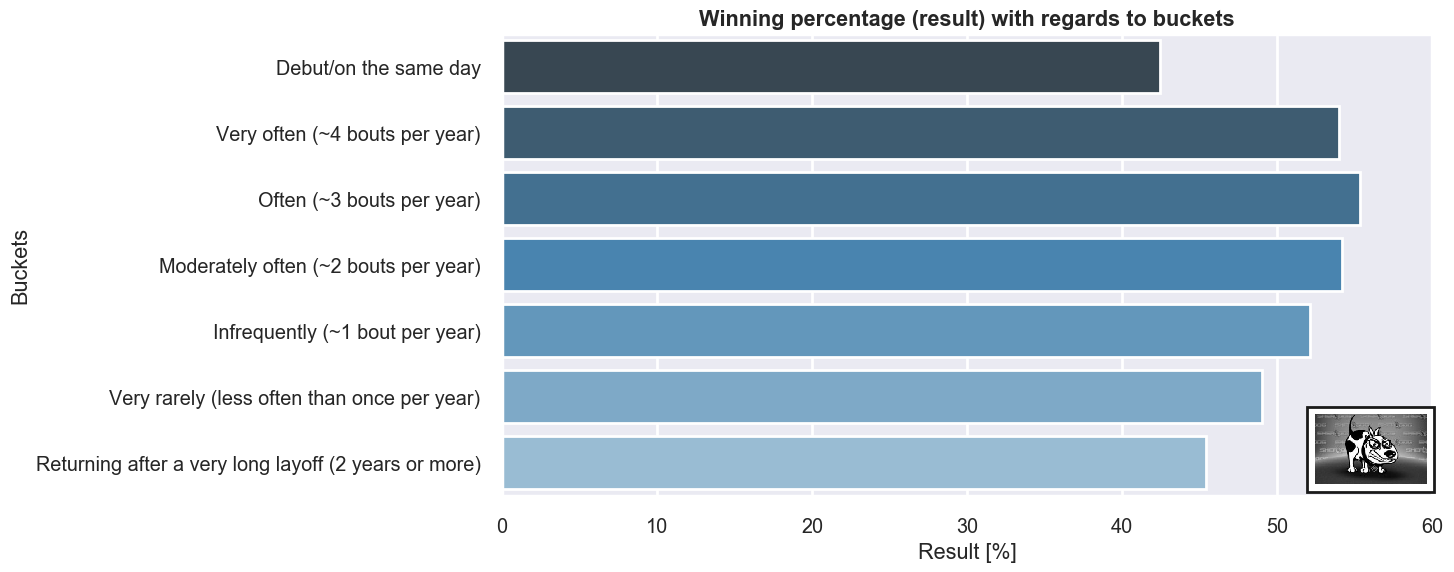

In [492]:
# Chart representing a result as percentages with reagrds to buckets for all fights recorded in the Sherdog's database.
plt.figure(figsize=(12,6), dpi= 100)
sns.set(style='darkgrid')
sns.set_context('poster', font_scale = 0.65)
ax = sns.barplot(sherdog_true_pct.values, sherdog_true_pct.index, palette="Blues_d")
ax.set_xlim(0, 60)
ax.set(xlabel='Result [%]', ylabel='Buckets')

sher_logo = mpimg.imread('sherdog.jpg')
imagebox = OffsetImage(sher_logo, zoom=0.4)
ab = AnnotationBbox(imagebox, (56, 5.8))
ax.add_artist(ab)

plt.title('Winning percentage (result) with regards to buckets', fontweight='bold')
plt.show()

In [493]:
# Dynamics of change for each category with regards to the result.
sherdog_pct_sorted.pct_change()

Often (~3 bouts per year)                                    NaN
Moderately often (~2 bouts per year)                   -0.020054
Very often (~4 bouts per year)                         -0.004533
Infrequently (~1 bout per year)                        -0.033720
Very rarely (less often than once per year)            -0.059397
Returning after a very long layoff (2 years or more)   -0.074272
Debut/on the same day                                  -0.065864
Name: Descriptive_interval, dtype: float64

In [494]:
# Total amount of observations for each bucket.
all_fights_count

Debut/on the same day                                   138034
Very often (~4 bouts per year)                          130115
Infrequently (~1 bout per year)                          74233
Moderately often (~2 bouts per year)                     61891
Often (~3 bouts per year)                                45663
Very rarely (less often than once per year)              35188
Returning after a very long layoff (2 years or more)     19223
Name: Descriptive_interval, dtype: int64

The highest amount of observations was registered for the "debut/on the same day" category and for intervals labeled as 'Very Often'. It should not be much of a surprise that the lowest amount of observations landed in low frequency intervals. Fighters are benefiting from fighting more often in many ways - the most obvious, is of course, the financial reason. Suffice to say, taking fights less often than once per year is rather a consequence of exceptional circumstances than a conscious strategy.

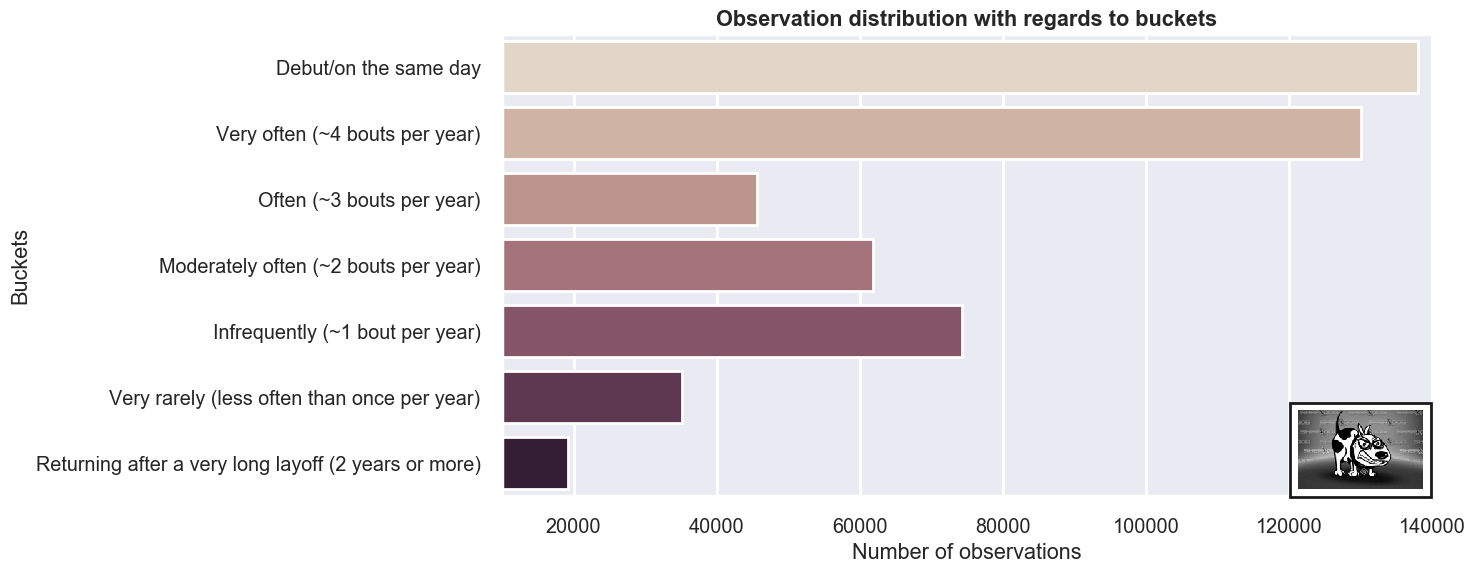

In [495]:
# Chart, representing a number of observations with regards to buckets for all fights recorded in the Sherdog's database.
plt.figure(figsize=(12,6), dpi= 100)
sns.set(style='darkgrid')
sns.set_context('poster', font_scale = 0.65)
ax = sns.barplot(all_fights_count.values, all_fights_count.index, palette="ch:.25")
ax.set_xlim(10000, 140000)
ax.set(xlabel='Number of observations', ylabel='Buckets')

sher_logo = mpimg.imread('sherdog.jpg')
imagebox = OffsetImage(sher_logo, zoom=0.45)
ab = AnnotationBbox(imagebox, (130000, 5.8))
ax.add_artist(ab)

plt.title('Observation distribution with regards to buckets', fontweight='bold')
plt.show()

In [496]:
# Creating a cross-table for the sake of visualization fights outcome distribution.
sherdog_cross = pd.crosstab(sherdog_selected_data['Descriptive_interval'], sherdog_selected_data['Result'])

<Figure size 1000x600 with 0 Axes>

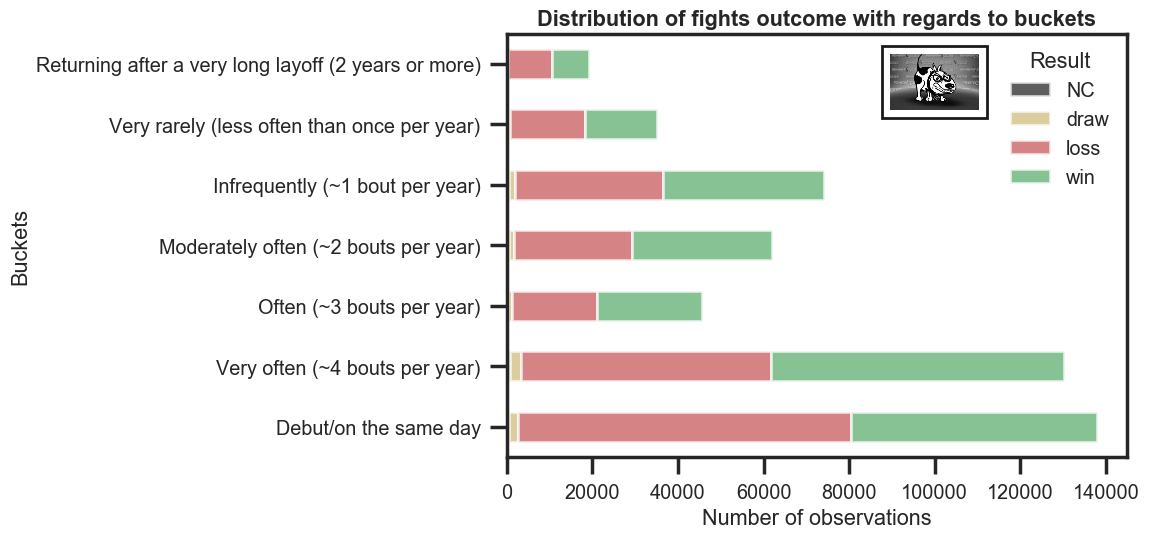

In [497]:
# Chart representing fights outcome distribution with reagrds to buckets for all fights recorded in the Sherdog's database.
plt.figure(figsize=(10,6), dpi= 100)
plt.style.use('seaborn')
sns.set(style='ticks')
sns.set_context('poster', font_scale = 0.65)
ax = sherdog_cross.plot.barh(stacked=True, alpha=0.7, color=['k', 'y', 'r', 'g'])
ax.set(ylabel='Buckets', xlabel='Number of observations')

sher_logo = mpimg.imread('sherdog.jpg')
imagebox = OffsetImage(sher_logo, zoom=0.32)
ab = AnnotationBbox(imagebox, (100000, 5.7))
ax.add_artist(ab)

plt.title('Distribution of fights outcome with regards to buckets', fontweight='bold')
plt.show()

## Segment 3: *Loading, preparing and analyzing the UFC's roster data*

In [498]:
import re

In [499]:
# Loading data for the UFC roster.
ufc_data = pd.read_csv('sherdog-UFC_roster.csv', header=0, sep=";", engine='python')

In [500]:
ufc_data[0:10]

,Fighter,Opponent,Result,Event,Event_date,Method,Referee,Round,Time
0,Shamil Abdurakhimov,Curtis Blaydes,loss,UFC 242 - Khabib vs. Poirier,Sep / 07 / 2019,TKO (Elbow and Punch),Marc Goddard,2,02:22
1,Shamil Abdurakhimov,Marcin Tybura,win,UFC Fight Night 149 - Overeem vs. Oleynik,Apr / 20 / 2019,TKO (Punches),Herb Dean,2,03:15
2,Shamil Abdurakhimov,Andrei Arlovski,win,UFC Fight Night 136 - Hunt vs. Oleynik,Sep / 15 / 2018,Decision (Unanimous),Leon Roberts,3,05:00
3,Shamil Abdurakhimov,Chase Sherman,win,UFC Fight Night 122 - Bisping vs. Gastelum,Nov / 25 / 2017,KO (Punches),Steve Perceval,1,01:24
4,Shamil Abdurakhimov,Derrick Lewis,loss,UFC Fight Night 102 - Lewis vs. Abdurakhimov,Dec / 09 / 2016,TKO (Punches),Dan Miragliotta,4,03:42
5,Shamil Abdurakhimov,Walt Harris,win,UFC Fight Night 96 - Lineker vs. Dodson,Oct / 01 / 2016,Decision (Split),Herb Dean,3,05:00
6,Shamil Abdurakhimov,Anthony Hamilton,win,UFC Fight Night 83 - Cerrone vs. Oliveira,Feb / 21 / 2016,Decision (Unanimous),Chip Snider,3,05:00
7,Shamil Abdurakhimov,Timothy Johnson,loss,UFC Fight Night 63 - Mendes vs. Lamas,Apr / 04 / 2015,TKO (Punches),Mike King,1,04:57
8,Shamil Abdurakhimov,Kenny Garner,win,M-1 Challenge 49 - Battle in the Mountains,Jun / 07 / 2014,Decision (Unanimous),Viktor Korneev,3,05:00
9,Shamil Abdurakhimov,Neil Grove,win,Tech-Krep FC - Southern Front 2,Oct / 04 / 2013,Decision (Unanimous),Ashot Ashughyan,3,05:00


In [501]:
# Creating a data frame copy which was reduced to essential columns.
ufc_selected_data = ufc_data[['Fighter', 'Result', 'Event_date']].copy()

In [502]:
# Checking if there are any missing values in the 'Event_date' column.
ufc_selected_data[ufc_selected_data['Event_date'].isna()]

,Fighter,Result,Event_date


In [503]:
# Converting strings to datetime values in the 'Event_date' column.
ufc_converted_dates = []
for i in range(len(ufc_selected_data['Event_date'])):
    ufc_converted_dates.append(parse(ufc_selected_data['Event_date'][i]))

In [504]:
# Assigning the converted data to the 'Event_date' column.
ufc_selected_data['Event_date'] = ufc_converted_dates

In [505]:
ufc_selected_data[0:10]

,Fighter,Result,Event_date
0,Shamil Abdurakhimov,loss,2019-09-07
1,Shamil Abdurakhimov,win,2019-04-20
2,Shamil Abdurakhimov,win,2018-09-15
3,Shamil Abdurakhimov,win,2017-11-25
4,Shamil Abdurakhimov,loss,2016-12-09
5,Shamil Abdurakhimov,win,2016-10-01
6,Shamil Abdurakhimov,win,2016-02-21
7,Shamil Abdurakhimov,loss,2015-04-04
8,Shamil Abdurakhimov,win,2014-06-07
9,Shamil Abdurakhimov,win,2013-10-04


In [506]:
# Creating time intervals between fights for each fighter.
ufc_intervals = []
for i in range(len(ufc_selected_data['Fighter']) - 1):
    if ufc_selected_data['Fighter'][i] == ufc_selected_data['Fighter'][i + 1]:
        ufc_intervals.append(ufc_selected_data['Event_date'][i] - ufc_selected_data['Event_date'][i + 1])
        ufc_intervals[i] = ufc_intervals[i].days
    else:
        ufc_intervals.append(0)
ufc_intervals.append(0)   # appending last interval (0) to the last fight in database.

In [507]:
# Creating and assigning time intervals to a new column.
ufc_selected_data['Time_interval'] = ufc_intervals

In [508]:
ufc_selected_data[0:10]

,Fighter,Result,Event_date,Time_interval
0,Shamil Abdurakhimov,loss,2019-09-07,140
1,Shamil Abdurakhimov,win,2019-04-20,217
2,Shamil Abdurakhimov,win,2018-09-15,294
3,Shamil Abdurakhimov,win,2017-11-25,351
4,Shamil Abdurakhimov,loss,2016-12-09,69
5,Shamil Abdurakhimov,win,2016-10-01,223
6,Shamil Abdurakhimov,win,2016-02-21,323
7,Shamil Abdurakhimov,loss,2015-04-04,301
8,Shamil Abdurakhimov,win,2014-06-07,246
9,Shamil Abdurakhimov,win,2013-10-04,551


Repeating the same actions for the UFC's roster data - the same buckets will be assigned to data in order to make it comparable to the previous chapter.

In [509]:
# Preparing buckets and labels for each category and assigning them to 'cats' variable.
bins_ufc = [0, 1, 91, 121, 183, 366, 729, 10000]
group_names = ['Debut/on the same day', 
               'Very often (~4 bouts per year)', 
               'Often (~3 bouts per year)', 
               'Moderately often (~2 bouts per year)', 
               'Infrequently (~1 bout per year)', 
               'Very rarely (less often than once per year)',
               'Returning after a very long layoff (2 years or more)']
cats_ufc = pd.cut(ufc_selected_data['Time_interval'], bins_ufc, labels=group_names, right=False)

In [510]:
# Creating and assigning buckets to a new column.
ufc_selected_data['Descriptive_interval'] = cats_ufc

In [511]:
ufc_selected_data[0:20]

,Fighter,Result,Event_date,Time_interval,Descriptive_interval
0,Shamil Abdurakhimov,loss,2019-09-07,140,Moderately often (~2 bouts per year)
1,Shamil Abdurakhimov,win,2019-04-20,217,Infrequently (~1 bout per year)
2,Shamil Abdurakhimov,win,2018-09-15,294,Infrequently (~1 bout per year)
3,Shamil Abdurakhimov,win,2017-11-25,351,Infrequently (~1 bout per year)
4,Shamil Abdurakhimov,loss,2016-12-09,69,Very often (~4 bouts per year)
5,Shamil Abdurakhimov,win,2016-10-01,223,Infrequently (~1 bout per year)
6,Shamil Abdurakhimov,win,2016-02-21,323,Infrequently (~1 bout per year)
7,Shamil Abdurakhimov,loss,2015-04-04,301,Infrequently (~1 bout per year)
8,Shamil Abdurakhimov,win,2014-06-07,246,Infrequently (~1 bout per year)
9,Shamil Abdurakhimov,win,2013-10-04,551,Very rarely (less often than once per year)


In [512]:
# Assigning a 'Descriptive_interval' column to a variable.
ufc_brackets = ufc_selected_data['Descriptive_interval']

In [513]:
# Creating variables where interval data is assigned based on the type of fights' outcome.
ufc_all_fights_count = ufc_brackets.value_counts()
ufc_win_fights_count = ufc_brackets[ufc_selected_data['Result'] == 'win'].value_counts()
ufc_loss_fights_count = ufc_brackets[ufc_selected_data['Result'] == 'loss'].value_counts()
ufc_draw_fights_count = ufc_brackets[ufc_selected_data['Result'] == 'draw'].value_counts()
ufc_nc_fights_count = ufc_brackets[ufc_selected_data['Result'] == 'NC'].value_counts()

In [514]:
# Sum of all fights stored in the UFC's roster database.
ufc_all_fights_count.sum()

12979

In [515]:
# Sum of all fights ended with a victory and stored in the UFC's roster database.
ufc_win_fights_count.sum()

9730

In [516]:
# Sum of all fights ended with a loss and stored in the UFC's roster database.
ufc_loss_fights_count.sum()

3063

In [517]:
# Sum of all fights ended with a draw and stored in the UFC's roster database.
ufc_draw_fights_count.sum()

90

In [518]:
# Sum of all fights ended with no-contest and stored in the UFC's roster database.
ufc_nc_fights_count.sum()

96

In [519]:
# Checking for any missing values in the 'Descriptive_interval' column.
ufc_selected_data[ufc_selected_data['Descriptive_interval'].isna()]

,Fighter,Result,Event_date,Time_interval,Descriptive_interval


In [520]:
# Data validation - checking if there is any record that was not qualified as either a win, loss, draw or no-contest.
ufc_sum_of_brackets = (ufc_win_fights_count.sum() + ufc_loss_fights_count.sum() + ufc_draw_fights_count.sum() + 
ufc_nc_fights_count.sum())

if ufc_all_fights_count.sum() == ufc_sum_of_brackets:
    print('Verification successful!')

Verification successful!


In [521]:
# Assigning result (percentage ratio between amount of wins and total amount of wins and losses) to a variable.
ufc_pct = ufc_win_fights_count/(ufc_win_fights_count + ufc_loss_fights_count)

In [522]:
# Sorting results in ascending order.
ufc_pct_sorted = ufc_pct.sort_values(ascending=False)

In [523]:
# Converting fractions to percentages.
ufc_true_pct = ufc_pct * 100

In [524]:
ufc_pct_sorted

Debut/on the same day                                   0.892052
Returning after a very long layoff (2 years or more)    0.830357
Very often (~4 bouts per year)                          0.800858
Often (~3 bouts per year)                               0.742574
Moderately often (~2 bouts per year)                    0.734148
Infrequently (~1 bout per year)                         0.722242
Very rarely (less often than once per year)             0.703540
Name: Descriptive_interval, dtype: float64

There is a striking difference, **ranging from 20 to 30 percentage points** in the result ratio of the UFC's roster and the entire database. This should not be a surprise since the UFC is currently treated as the best MMA organization in the world by virtue of being stacked with the highest amount of talented MMA fighters. In this case, it is fair to say that data goes hand in hand with intuition. MMA enthusiasts around the world know that most elite fighters can be found in the UFC.
Another interesting observation applies to debutants - **UFC fighters won over *89%* of fights represented by the "debut/in the same day" bucket. Taking into account that over *80%* of these observations were, in fact, debuts, it is fair to say that more than *70%* of fighters under current UFC contract won their MMA debut.**

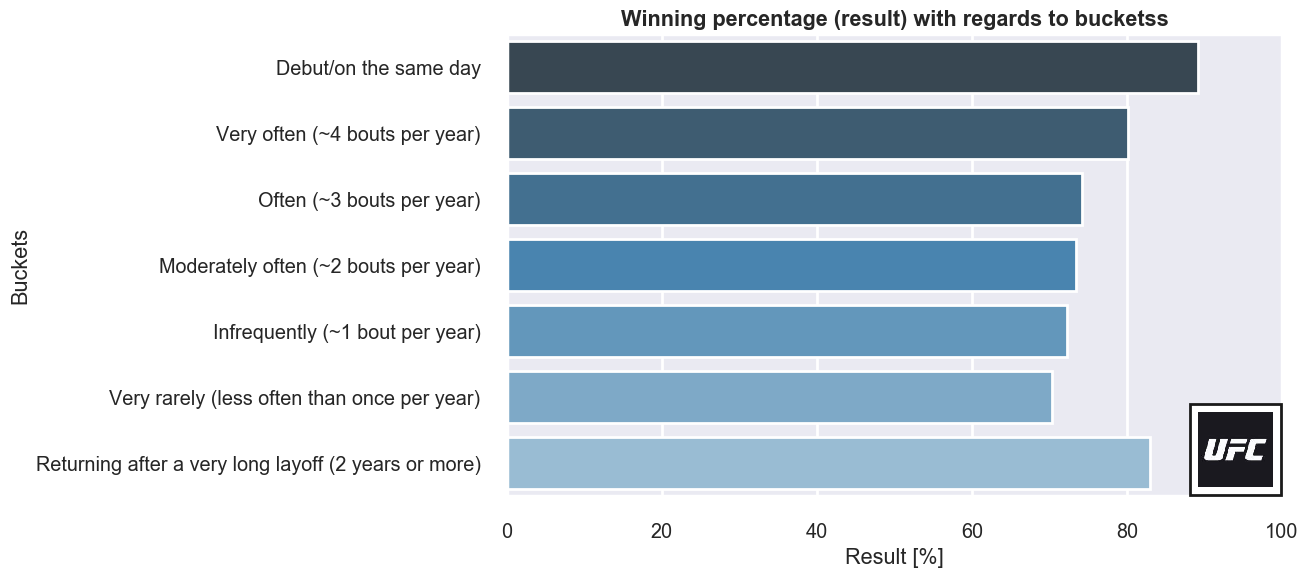

In [525]:
# Chart representing a result as percentages with reagrds to buckets for all fights recorded in the UFC's roster database.
plt.figure(figsize=(10,6), dpi= 100)
sns.set(style='darkgrid')
sns.set_context('poster', font_scale = 0.65)
ax = sns.barplot(ufc_true_pct.values, ufc_true_pct.index, palette="Blues_d")
ax.set_xlim(0, 100)
ax.set(xlabel='Result [%]', ylabel='Buckets')

ufc_logo = mpimg.imread('ufc.jpg')
imagebox = OffsetImage(ufc_logo, zoom=0.3)
ab = AnnotationBbox(imagebox, (94, 5.8))
ax.add_artist(ab)

plt.title('Winning percentage (result) with regards to bucketss', fontweight='bold')
plt.show()

In [526]:
# Total amount of observations for each bucket.
ufc_all_fights_count

Very often (~4 bouts per year)                          3547
Moderately often (~2 bouts per year)                    3065
Infrequently (~1 bout per year)                         2861
Often (~3 bouts per year)                               1851
Debut/on the same day                                    851
Very rarely (less often than once per year)              689
Returning after a very long layoff (2 years or more)     115
Name: Descriptive_interval, dtype: int64

I have to admit that it is quite interesting that fighters returning after a very long layoff scored such a high result. Let us examine why this can be significant. First of all, there are only 115 observations recorded for this bucket. It represents less than *1%* of all observations collected from the UFC's roster. It is worth mentioning that for Sherdog's database this bucket represented almost *4%* of the total. Considering the above, I suggest being very careful with drawing conclusions at this point.

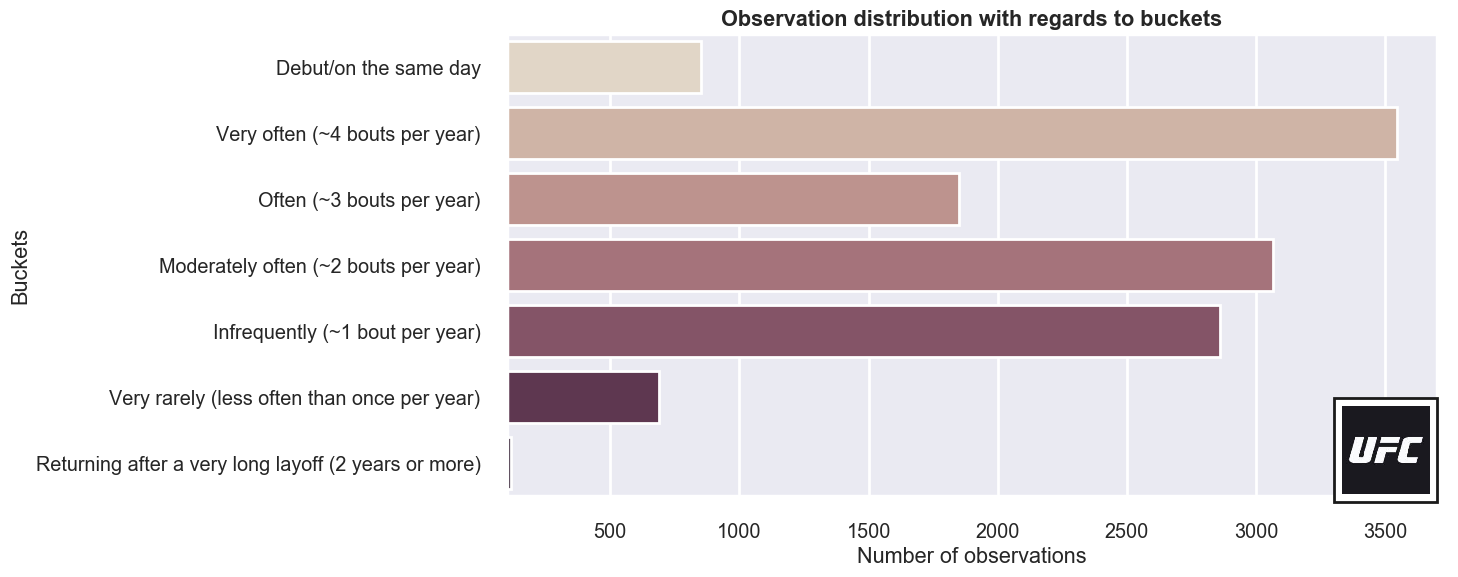

In [527]:
# Chart, representing a number of observations with regards to buckets for all fights recorded in the UFC's roster database.
plt.figure(figsize=(12,6), dpi= 100)
sns.set(style='darkgrid')
sns.set_context('poster', font_scale = 0.65)
ax = sns.barplot(ufc_all_fights_count.values, ufc_all_fights_count.index, palette="ch:.25")
ax.set_xlim(100, 3700)
ax.set(xlabel='Number of observations', ylabel='Buckets')

ufc_logo = mpimg.imread('ufc.jpg')
imagebox = OffsetImage(ufc_logo, zoom=0.35)
ab = AnnotationBbox(imagebox, (3500, 5.8))
ax.add_artist(ab)

plt.title('Observation distribution with regards to buckets', fontweight='bold')
plt.show()

In [528]:
# Ratio of 'Returning after very long layoff (2 years or more)' bucket and all recorded fights in UFC roster database.
ufc_all_fights_count[6] / ufc_all_fights_count.sum()

0.008860466908082287

In [529]:
# Ratio of 'Returning after very long layoff (2 years or more)' bucket and all recorded fights in Sherdog database.
all_fights_count[6] / all_fights_count.sum()

0.03811463139465487

For buckets that are representing the range from 1 to 3 bouts per year there are only minor differences between results (the difference is not exceeding *2 percentage points*). It resembles results for the Sherdog database in regards to these categories, although, as it was previously mentioned that the results for the UFC's roster are respectively higher. **We can safely conclude that fighting with frequency corresponding to one, two or three bouts per year, will not have any significant positive, or negative impact on results.** This conclusion is applicable to all fighters (Sherdog database) as well as to the UFC's roster.

The category in which the fighters fight most frequently looks quite interesting. It scored a 6 percentage point higher result than intervals between 1-3 bouts per year. This was not the case for the whole database, though. Does it mean that the UFC fighters should fight more often to increase their chances of winning? Not necessarily one possible explanation might be connected to the strategy that was used by many fighters approaching the UFC contract. This strategy relied on getting as many fights as possible with relatively low-skilled opponents. The strategy basically came down to winning as many fights as possible, regardless of the opponents' skill level. As disclosed by many managers - the UFC was rewarding quantity over quality.

That seems like a good reason to dive into the UFC's roster data, narrowing down results to fights **that happened inside the UFC**. Hopefully, this can shed some light on this issue by eliminating the 'skill difference' factor.

In [530]:
# Creating a cross-table for the sake of visualization fights outcome distribution.
ufc_cross = pd.crosstab(ufc_selected_data['Descriptive_interval'], ufc_selected_data['Result'])

<Figure size 900x600 with 0 Axes>

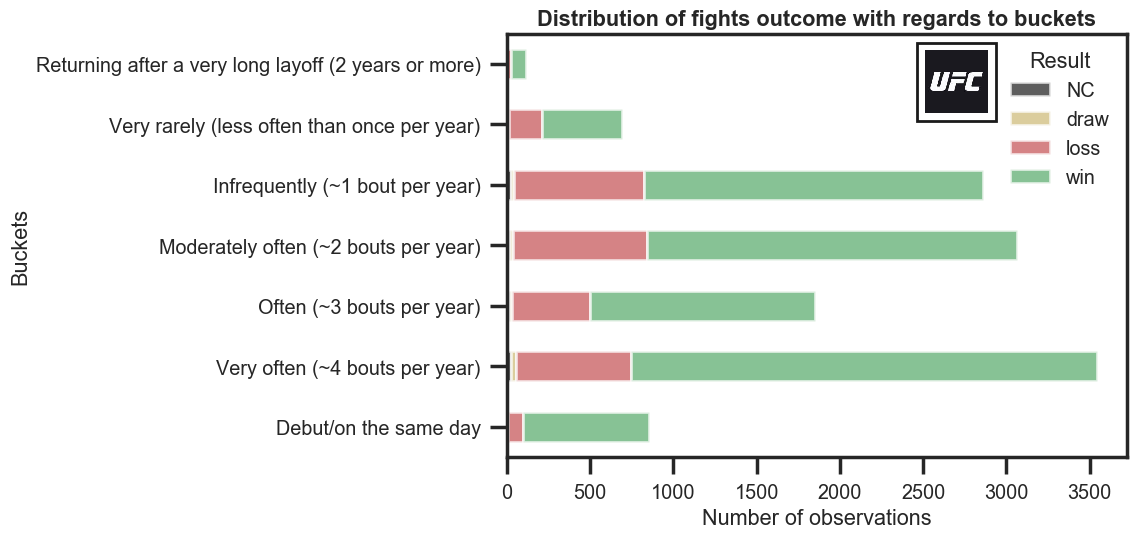

In [531]:
# Chart representing fights outcome distribution with reagrds to buckets for all fights recorded in the UFC's database.
plt.figure(figsize=(9,6), dpi= 100)
plt.style.use('seaborn')
sns.set(style='ticks')
sns.set_context('poster', font_scale = 0.65)
ax = ufc_cross.plot.barh(stacked=True, alpha=0.7, color=['k', 'y', 'r', 'g'])
ax.set(ylabel='Buckets', xlabel='Number of observations')

ufc_logo = mpimg.imread('ufc.jpg')
imagebox = OffsetImage(ufc_logo, zoom=0.25)
ab = AnnotationBbox(imagebox, (2700, 5.7))
ax.add_artist(ab)

plt.title('Distribution of fights outcome with regards to buckets', fontweight='bold')
plt.show()

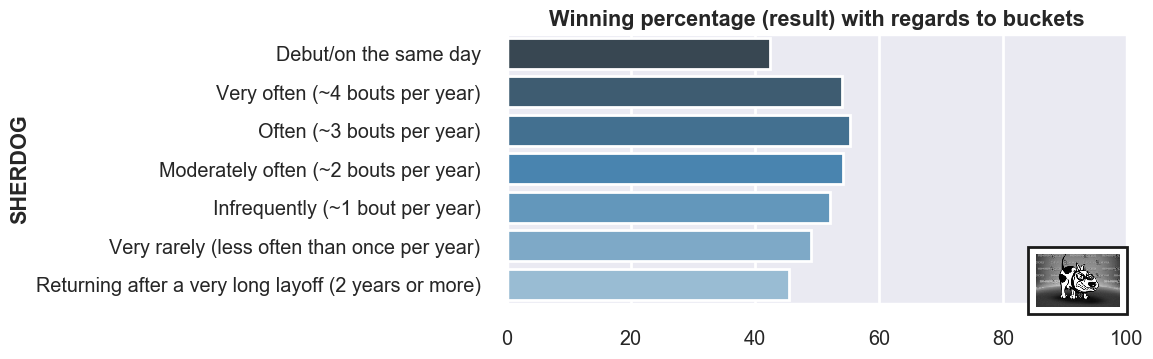

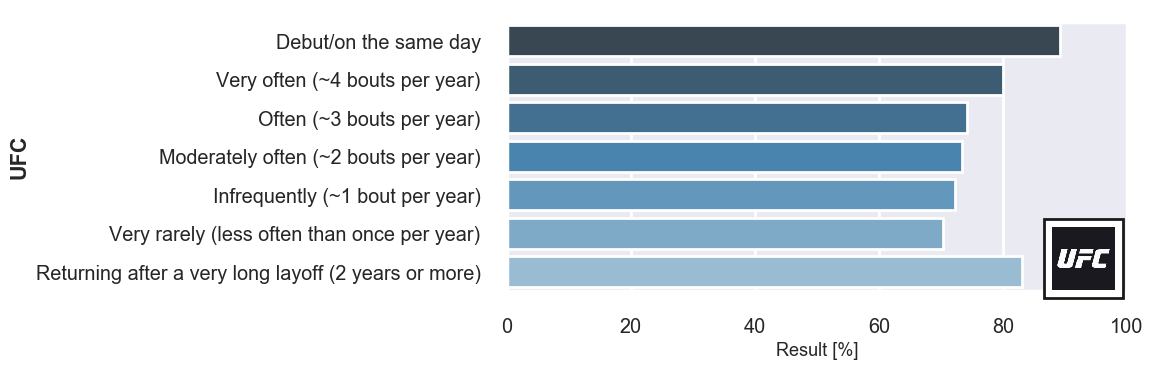

In [532]:
# Comparing charts which are representing the result as percentages with regards to buckets for all fights recorded 
# in the UFC's roster and the Sherdog's database.
sns.set(style='darkgrid')
sns.set_context('poster', font_scale = 0.65)

plt.figure(figsize=(8,3.5), dpi= 100)

ax1 = sns.barplot(sherdog_true_pct.values, sherdog_true_pct.index, palette="Blues_d")
ax1.set_xlim(0, 100)
ax1.set_ylabel('SHERDOG', fontweight='heavy')

imagebox = OffsetImage(sher_logo, zoom=0.3)
ab = AnnotationBbox(imagebox, (92, 5.9))
ax1.add_artist(ab)

plt.figure(figsize=(8,3.5), dpi= 100)
ax2 = sns.barplot(ufc_true_pct.values, ufc_true_pct.index, palette="Blues_d")
ax2.set_xlim(0, 100)
ax2.set_xlabel('Result [%]', fontsize='smaller')
ax2.set_ylabel('UFC', fontweight='heavy')

imagebox = OffsetImage(ufc_logo, zoom=0.25)
ab2 = AnnotationBbox(imagebox, (93, 5.65))
ax2.add_artist(ab2)

ax1.set_title('Winning percentage (result) with regards to buckets', fontweight='bold')
plt.show()

## Segment 4: *Analyzing the UFC roster with regards to fights that  took place in the UFC exclusively. Gender and weight class breakdown*

In [533]:
# Creating a copy of 'Event' table from the UFC roster data frame.
ufc_selected_data['Event'] = ufc_data['Event'].copy()

In [534]:
ufc_selected_data[0:10]

,Fighter,Result,Event_date,Time_interval,Descriptive_interval,Event
0,Shamil Abdurakhimov,loss,2019-09-07,140,Moderately often (~2 bouts per year),UFC 242 - Khabib vs. Poirier
1,Shamil Abdurakhimov,win,2019-04-20,217,Infrequently (~1 bout per year),UFC Fight Night 149 - Overeem vs. Oleynik
2,Shamil Abdurakhimov,win,2018-09-15,294,Infrequently (~1 bout per year),UFC Fight Night 136 - Hunt vs. Oleynik
3,Shamil Abdurakhimov,win,2017-11-25,351,Infrequently (~1 bout per year),UFC Fight Night 122 - Bisping vs. Gastelum
4,Shamil Abdurakhimov,loss,2016-12-09,69,Very often (~4 bouts per year),UFC Fight Night 102 - Lewis vs. Abdurakhimov
5,Shamil Abdurakhimov,win,2016-10-01,223,Infrequently (~1 bout per year),UFC Fight Night 96 - Lineker vs. Dodson
6,Shamil Abdurakhimov,win,2016-02-21,323,Infrequently (~1 bout per year),UFC Fight Night 83 - Cerrone vs. Oliveira
7,Shamil Abdurakhimov,loss,2015-04-04,301,Infrequently (~1 bout per year),UFC Fight Night 63 - Mendes vs. Lamas
8,Shamil Abdurakhimov,win,2014-06-07,246,Infrequently (~1 bout per year),M-1 Challenge 49 - Battle in the Mountains
9,Shamil Abdurakhimov,win,2013-10-04,551,Very rarely (less often than once per year),Tech-Krep FC - Southern Front 2


In [535]:
# Assigning sequence of columns to the variable.
columns_ufc = ufc_selected_data.columns.tolist()

In [536]:
columns_ufc

['Fighter',
 'Result',
 'Event_date',
 'Time_interval',
 'Descriptive_interval',
 'Event']

In [537]:
# Changing sequence of columns in the data frame.
columns_ufc = [columns_ufc[0], columns_ufc[1], columns_ufc[-1], columns_ufc[2], columns_ufc[3], columns_ufc[4]]

In [538]:
# Replacing sequence of columns in data frame with a new sequence.
ufc_selected_data = ufc_selected_data[columns_ufc]

In [539]:
ufc_selected_data[0:10]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval
0,Shamil Abdurakhimov,loss,UFC 242 - Khabib vs. Poirier,2019-09-07,140,Moderately often (~2 bouts per year)
1,Shamil Abdurakhimov,win,UFC Fight Night 149 - Overeem vs. Oleynik,2019-04-20,217,Infrequently (~1 bout per year)
2,Shamil Abdurakhimov,win,UFC Fight Night 136 - Hunt vs. Oleynik,2018-09-15,294,Infrequently (~1 bout per year)
3,Shamil Abdurakhimov,win,UFC Fight Night 122 - Bisping vs. Gastelum,2017-11-25,351,Infrequently (~1 bout per year)
4,Shamil Abdurakhimov,loss,UFC Fight Night 102 - Lewis vs. Abdurakhimov,2016-12-09,69,Very often (~4 bouts per year)
5,Shamil Abdurakhimov,win,UFC Fight Night 96 - Lineker vs. Dodson,2016-10-01,223,Infrequently (~1 bout per year)
6,Shamil Abdurakhimov,win,UFC Fight Night 83 - Cerrone vs. Oliveira,2016-02-21,323,Infrequently (~1 bout per year)
7,Shamil Abdurakhimov,loss,UFC Fight Night 63 - Mendes vs. Lamas,2015-04-04,301,Infrequently (~1 bout per year)
8,Shamil Abdurakhimov,win,M-1 Challenge 49 - Battle in the Mountains,2014-06-07,246,Infrequently (~1 bout per year)
9,Shamil Abdurakhimov,win,Tech-Krep FC - Southern Front 2,2013-10-04,551,Very rarely (less often than once per year)


In [540]:
# Creating a variable and assigning fights that took place in the UFC exclusively.
ufc_events_only = ufc_selected_data[ufc_selected_data['Event'].str.contains("^UFC\s", flags=re.IGNORECASE, regex=True)].copy()

In [541]:
ufc_events_only[0:20]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval
0,Shamil Abdurakhimov,loss,UFC 242 - Khabib vs. Poirier,2019-09-07,140,Moderately often (~2 bouts per year)
1,Shamil Abdurakhimov,win,UFC Fight Night 149 - Overeem vs. Oleynik,2019-04-20,217,Infrequently (~1 bout per year)
2,Shamil Abdurakhimov,win,UFC Fight Night 136 - Hunt vs. Oleynik,2018-09-15,294,Infrequently (~1 bout per year)
3,Shamil Abdurakhimov,win,UFC Fight Night 122 - Bisping vs. Gastelum,2017-11-25,351,Infrequently (~1 bout per year)
4,Shamil Abdurakhimov,loss,UFC Fight Night 102 - Lewis vs. Abdurakhimov,2016-12-09,69,Very often (~4 bouts per year)
5,Shamil Abdurakhimov,win,UFC Fight Night 96 - Lineker vs. Dodson,2016-10-01,223,Infrequently (~1 bout per year)
6,Shamil Abdurakhimov,win,UFC Fight Night 83 - Cerrone vs. Oliveira,2016-02-21,323,Infrequently (~1 bout per year)
7,Shamil Abdurakhimov,loss,UFC Fight Night 63 - Mendes vs. Lamas,2015-04-04,301,Infrequently (~1 bout per year)
25,Klidson Abreu,loss,UFC Fight Night 163 - Magomedsharipov vs. Kattar,2019-11-09,112,Often (~3 bouts per year)
26,Klidson Abreu,win,UFC on ESPN 4 - Dos Anjos vs. Edwards,2019-07-20,147,Moderately often (~2 bouts per year)


In [542]:
# Assigning the 'Descriptive_interval' column to a variable.
ufc_events_brackets = ufc_events_only['Descriptive_interval']

In [543]:
# Creating variables where the interval data is assigned based on a type of a fight outcome.
ufc_events_all_fights_count = ufc_events_brackets.value_counts()
ufc_events_win_fights_count = ufc_events_brackets[ufc_events_only['Result'] == 'win'].value_counts()
ufc_events_loss_fights_count = ufc_events_brackets[ufc_events_only['Result'] == 'loss'].value_counts()
ufc_events_draw_fights_count = ufc_events_brackets[ufc_events_only['Result'] == 'draw'].value_counts()
ufc_events_nc_fights_count = ufc_events_brackets[ufc_events_only['Result'] == 'NC'].value_counts()

In [544]:
# Sum of all fights that took place in the UFC with regards to the UFC's roster database.
ufc_events_all_fights_count.sum()

4755

In [545]:
# Sum of all fights that took place in the UFC and ended up with a victory with regards to the UFC's roster database.
ufc_events_win_fights_count.sum()

2796

In [546]:
# Sum of all fights that took place inside the UFC and ended up with a loss with regards to the UFC's roster database.
ufc_events_loss_fights_count.sum()

1889

In [547]:
# Sum of all fights that took place in the UFC and ended up with a draw with regards to UFC's roster database.
ufc_events_draw_fights_count.sum()

28

In [548]:
# Sum of all fights that took place inside the UFC and ended up as no-contest with regards to UFC's roster database.
ufc_events_nc_fights_count.sum()

42

In [549]:
# Checking if there are any missing values in the 'Descriptive_interval' column.
ufc_events_only[ufc_events_only['Descriptive_interval'].isna()]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval


In [550]:
# Data validation - checking if there is any record that was not qualified as either a win, loss, draw or no-contest.
ufc_events_sum_of_brackets = (ufc_events_win_fights_count.sum() + ufc_events_loss_fights_count.sum() + 
ufc_events_draw_fights_count.sum() + ufc_events_nc_fights_count.sum())

if ufc_events_all_fights_count.sum() == ufc_events_sum_of_brackets:
    print('Verification successful!')

Verification successful!


In [551]:
# Assigning result (percentage ratio between amount of wins and total amount of wins and losses) to a variable.
ufc_events_pct = ufc_events_win_fights_count/(ufc_events_win_fights_count + ufc_events_loss_fights_count)

In [552]:
# Sorting results in ascending order.
ufc_events_pct_sorted = ufc_events_pct.sort_values(ascending=False)

In [553]:
ufc_events_pct_sorted

Returning after a very long layoff (2 years or more)    0.666667
Infrequently (~1 bout per year)                         0.616059
Moderately often (~2 bouts per year)                    0.610892
Often (~3 bouts per year)                               0.582744
Very often (~4 bouts per year)                          0.555172
Very rarely (less often than once per year)             0.544413
Debut/on the same day                                   0.000000
Name: Descriptive_interval, dtype: float64

In [554]:
ufc_events_all_fights_count

Moderately often (~2 bouts per year)                    1542
Infrequently (~1 bout per year)                         1504
Often (~3 bouts per year)                                721
Very often (~4 bouts per year)                           587
Very rarely (less often than once per year)              355
Returning after a very long layoff (2 years or more)      45
Debut/on the same day                                      1
Name: Descriptive_interval, dtype: int64

As it turns out, the highest result can be attributed to the category labeled as 'Returning after a very long layoff (2 years or more)'. This finding raises many questions such as: Is 'ring rust' not real? Does a fighter benefit from a very long layoff and if so, why is that? Does a fighter receive any special treatment when it comes to matchmaking after coming back from a very long layoff? We cannot rule out that indeed, the fighters in this group were being matched with 'easier' or 'less skilled' opponents, than they would have been otherwise. The analysis does not provide any kind of opponent distinction or rating which can possibly be helpful in edge-cases like the one we have just encountered. That being said, the amount of data we are working with should enable further inference in regard to more centric intervals.

We can observe that the result for intervals between 1 and 2 fights per year is almost identical and the category corresponding to frequency of 3 bouts per year does not fall behind (*the difference is lower than 3 percentage points*). **These results overlap the findings for the whole UFC roster dataset**. We can safely come to the conclusion that:

*'...fighting with frequency corresponding to one, two or three bouts per year will not have any significant positive or negative impact on the results.'*

There is a very interesting dynamic happening with regards to the category which represents the highest frequency. One of the reasons for diving into data constrained by the fights that have happened inside the UFC, was a hunch, that the high result scored by this interval, was mostly dictated by the bouts that happened prior to the fighter joining the UFC. The 'Very often' interval scored a 6 percentage points higher result than the intervals ranging from 1 to 3 bouts per year. We can see that this situation was reversed and this frequency is now *6 percentage points* below 1-3 intervals. It looks like fighting that often is not the best strategy, result-wise, for fighters that are already in the UFC.

The bucket representing very rare frequency (less often than once per year) scored  the lowest result once again. It is fair to conclude that **fighting within this time interval makes positive results less likely to happen for the UFC fighters.**

As we can see, the debut category is no longer relevant in the view of the current constraints - there is only one fight that belongs to this category - CM Punk's debut. Unsurprisingly, the bout ended with the debutant's loss.

Additionally, we confirmed that the fighting frequency between 1 and 2 fights per year is not only the desirable frequency from the UFC schedule perspective, but in fact, the most common frequency for UFC fights with regards to the UFC roster.

In [555]:
ufc_events_only[ufc_events_only['Descriptive_interval'] == 'Debut/on the same day']

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval
8396,Phil Brooks,loss,UFC 203 - Miocic vs. Overeem,2016-09-10,0,Debut/on the same day


In [556]:
# Converting fractions to percentages.
ufc_events_true_pct = ufc_events_pct * 100

In [557]:
# Creating cross-table for the sake of visualization distribution of fights outcomes.
ufc_events_cross = pd.crosstab(ufc_events_only['Descriptive_interval'], ufc_events_only['Result'])

<Figure size 1200x600 with 0 Axes>

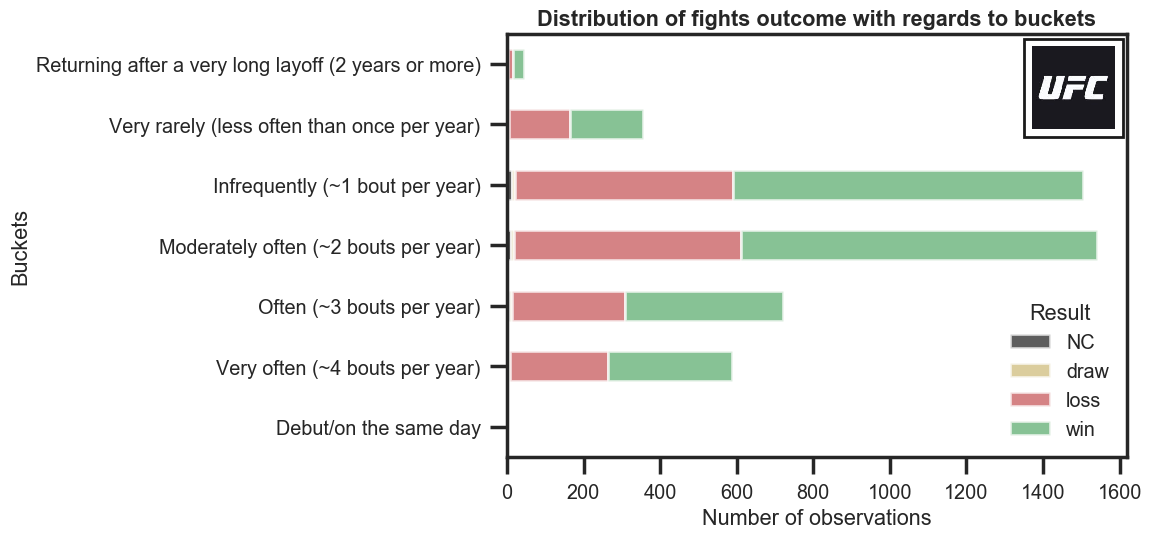

In [558]:
# Chart representing fights outcome distribution with reagrds to buckets for all fights recorded in the UFC for 
# current UFC roster.
plt.figure(figsize=(12,6), dpi= 100)
sns.set(style='ticks')
sns.set_context('poster', font_scale = 0.65)
ax = ufc_events_cross.plot.barh(stacked=True, alpha=0.7, color=['k', 'y', 'r', 'g'])
ax.set(ylabel='Buckets', xlabel='Number of observations')

ufc_logo = mpimg.imread('ufc.jpg')
imagebox = OffsetImage(ufc_logo, zoom=0.33)
ab = AnnotationBbox(imagebox, (1480, 5.6))
ax.add_artist(ab)

plt.title('Distribution of fights outcome with regards to buckets', fontweight='bold')
plt.show()

In [559]:
# Loading additional data related to the UFC roster (division, nickname).
roster = pd.read_csv('ufc-roster_v3.csv', header=0, sep=",", engine='python')

In [560]:
roster[0:10]

,Name,Division,Nickname
0,Shamil Abdurakhimov,Heavyweight,Abrek
1,Klidson Abreu,Light Heavyweight,White Bear
2,Juan Adams,Heavyweight,The Kraken
3,Israel Adesanya,Middleweight,The Last Stylebender
4,Kevin Aguilar,Featherweight,Angel of Death
5,Omari Akhmedov,Middleweight,Wolverine
6,Rostem Akman,Welterweight,NaN
7,Heili Alateng,Bantamweight,The Mongolian Knight
8,Junior Albini,Heavyweight,Baby
9,Iuri Alcantara,Bantamweight,Marajo


In [561]:
# Unifying fighters' name in both data frames.
ufc_events_only.loc[:, ['Fighter']] = ufc_events_only['Fighter'].str.upper()
roster.loc[:, 'Name'] = roster['Name'].str.upper()

In [562]:
ufc_events_only[0:10]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval
0,SHAMIL ABDURAKHIMOV,loss,UFC 242 - Khabib vs. Poirier,2019-09-07,140,Moderately often (~2 bouts per year)
1,SHAMIL ABDURAKHIMOV,win,UFC Fight Night 149 - Overeem vs. Oleynik,2019-04-20,217,Infrequently (~1 bout per year)
2,SHAMIL ABDURAKHIMOV,win,UFC Fight Night 136 - Hunt vs. Oleynik,2018-09-15,294,Infrequently (~1 bout per year)
3,SHAMIL ABDURAKHIMOV,win,UFC Fight Night 122 - Bisping vs. Gastelum,2017-11-25,351,Infrequently (~1 bout per year)
4,SHAMIL ABDURAKHIMOV,loss,UFC Fight Night 102 - Lewis vs. Abdurakhimov,2016-12-09,69,Very often (~4 bouts per year)
5,SHAMIL ABDURAKHIMOV,win,UFC Fight Night 96 - Lineker vs. Dodson,2016-10-01,223,Infrequently (~1 bout per year)
6,SHAMIL ABDURAKHIMOV,win,UFC Fight Night 83 - Cerrone vs. Oliveira,2016-02-21,323,Infrequently (~1 bout per year)
7,SHAMIL ABDURAKHIMOV,loss,UFC Fight Night 63 - Mendes vs. Lamas,2015-04-04,301,Infrequently (~1 bout per year)
25,KLIDSON ABREU,loss,UFC Fight Night 163 - Magomedsharipov vs. Kattar,2019-11-09,112,Often (~3 bouts per year)
26,KLIDSON ABREU,win,UFC on ESPN 4 - Dos Anjos vs. Edwards,2019-07-20,147,Moderately often (~2 bouts per year)


In [563]:
roster[0:10]

,Name,Division,Nickname
0,SHAMIL ABDURAKHIMOV,Heavyweight,Abrek
1,KLIDSON ABREU,Light Heavyweight,White Bear
2,JUAN ADAMS,Heavyweight,The Kraken
3,ISRAEL ADESANYA,Middleweight,The Last Stylebender
4,KEVIN AGUILAR,Featherweight,Angel of Death
5,OMARI AKHMEDOV,Middleweight,Wolverine
6,ROSTEM AKMAN,Welterweight,NaN
7,HEILI ALATENG,Bantamweight,The Mongolian Knight
8,JUNIOR ALBINI,Heavyweight,Baby
9,IURI ALCANTARA,Bantamweight,Marajo


In [564]:
# Merging both data frames.
ufc_events_only_div = pd.merge(ufc_events_only, roster, left_on='Fighter', 
                               right_on='Name', how='left').drop(['Name', 'Nickname'], axis=1)

In [565]:
ufc_events_only_div[0:10]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval,Division
0,SHAMIL ABDURAKHIMOV,loss,UFC 242 - Khabib vs. Poirier,2019-09-07,140,Moderately often (~2 bouts per year),Heavyweight
1,SHAMIL ABDURAKHIMOV,win,UFC Fight Night 149 - Overeem vs. Oleynik,2019-04-20,217,Infrequently (~1 bout per year),Heavyweight
2,SHAMIL ABDURAKHIMOV,win,UFC Fight Night 136 - Hunt vs. Oleynik,2018-09-15,294,Infrequently (~1 bout per year),Heavyweight
3,SHAMIL ABDURAKHIMOV,win,UFC Fight Night 122 - Bisping vs. Gastelum,2017-11-25,351,Infrequently (~1 bout per year),Heavyweight
4,SHAMIL ABDURAKHIMOV,loss,UFC Fight Night 102 - Lewis vs. Abdurakhimov,2016-12-09,69,Very often (~4 bouts per year),Heavyweight
5,SHAMIL ABDURAKHIMOV,win,UFC Fight Night 96 - Lineker vs. Dodson,2016-10-01,223,Infrequently (~1 bout per year),Heavyweight
6,SHAMIL ABDURAKHIMOV,win,UFC Fight Night 83 - Cerrone vs. Oliveira,2016-02-21,323,Infrequently (~1 bout per year),Heavyweight
7,SHAMIL ABDURAKHIMOV,loss,UFC Fight Night 63 - Mendes vs. Lamas,2015-04-04,301,Infrequently (~1 bout per year),Heavyweight
8,KLIDSON ABREU,loss,UFC Fight Night 163 - Magomedsharipov vs. Kattar,2019-11-09,112,Often (~3 bouts per year),Light Heavyweight
9,KLIDSON ABREU,win,UFC on ESPN 4 - Dos Anjos vs. Edwards,2019-07-20,147,Moderately often (~2 bouts per year),Light Heavyweight


In [566]:
# Checking if there are any missing values in the 'Division' column.
'''
There is a one missing value - it appears, that there is no information regarding this fighter's weight class on the UFC site, 
from where the data was collected. This row will be omitted in the further analysis.
'''

ufc_events_only_div[ufc_events_only_div['Division'].isna() == True]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval,Division
4274,ARIANE CARNELOSSI,loss,UFC Fight Night 159 - Rodriguez vs. Stephens,2019-09-21,120,Often (~3 bouts per year),NaN


In [567]:
# Creating a class to support a weight divisions data storage.
class WeightDivision(object):
    def __init__(self, name, gender):
        self.name = name
        self.gender = gender
        
        self.frame = None
        self.all_fights_counts = None
        self.win_fights_counts = None
        self.loss_fights_counts = None
        self.draw_fights_counts = None
        self.nc_fights_counts = None
    
    def set_frame(self):
        self.frame = ufc_events_only_div[ufc_events_only_div['Division'] == self.name]
    
    def set_fights_counts(self):
        column = self.frame['Descriptive_interval']
        
        self.all_fights_counts = column.value_counts()
        self.win_fights_counts = column[self.frame['Result'] == 'win'].value_counts()
        self.loss_fights_counts = column[self.frame['Result'] == 'loss'].value_counts()
        self.draw_fights_counts = column[self.frame['Result'] == 'draw'].value_counts()
        self.nc_fights_counts = column[self.frame['Result'] == 'NC'].value_counts()

In [568]:
# Dictionary storing weight-division and gender info.
weightclass_info = {
    'HW_div': ("Heavyweight", "M"),
    'LHW_div': ("Light Heavyweight", "M"),
    'MW_div': ("Middleweight", "M"),
    'WW_div': ("Welterweight", "M"),
    'LW_div': ("Lightweight", "M"),
    'FW_div': ("Featherweight", "M"),
    'BW_div': ("Bantamweight", "M"),
    'FLW_div': ("Flyweight", "M"),
    'WSW_div': ("Women's Strawweight", "F"),
    'WFLW_div': ("Women's Flyweight", "F"),
    'WBW_div': ("Women's Bantamweight", "F"),
    'WFW_div': ("Women's Featherweight", "F")
    
}

In [569]:
# Creating weight-divisions as class instances and appending them to the list.
weightclass_obj_list = []
for weightclass in weightclass_info.keys():
    obj = WeightDivision(weightclass_info[weightclass][0], (weightclass_info[weightclass][1]))
    obj.set_frame()
    obj.set_fights_counts()
    weightclass_obj_list.append(obj)

In [570]:
# Creating lists that are containing information regarding each division (amount of fights, wins, losses, draws, nc) 
# with gender breakdown.
mens_info = [0, 0, 0, 0, 0]
womens_info = [0, 0, 0, 0, 0]
for weightclass in weightclass_obj_list:
    all_counts = weightclass.all_fights_counts
    win_counts = weightclass.win_fights_counts
    loss_counts = weightclass.loss_fights_counts
    draw_counts = weightclass.draw_fights_counts
    nc_counts = weightclass.nc_fights_counts
    if weightclass.gender == 'M':
        mens_info[0] += all_counts
        mens_info[1] += win_counts
        mens_info[2] += loss_counts
        mens_info[3] += draw_counts
        mens_info[4] += nc_counts
    elif weightclass.gender == 'F':
        womens_info[0] += all_counts
        womens_info[1] += win_counts
        womens_info[2] += loss_counts
        womens_info[3] += draw_counts
        womens_info[4] += nc_counts

In [571]:
# Data validation - checking if sum of all the records in the data frame connected to each weight-class is equal to
# information stored in the 'all fights' variable for each class instance.
index = 0
df_sum = 0
obj_sum = 0
for weightclass in weightclass_info.keys():
    section = ufc_events_only_div[ufc_events_only_div['Division'] == weightclass_info[weightclass][0]]
    if len(section) == weightclass_obj_list[index].all_fights_counts.sum():
        df_sum += len(section)
        obj_sum += weightclass_obj_list[index].all_fights_counts.sum()
        print(f'Verification of {weightclass_obj_list[index].name} successful.')
    else:
        print(f'Verification of  {weightclass_obj_list[index].name} has failed!')
    index += 1

Verification of Heavyweight successful.
Verification of Light Heavyweight successful.
Verification of Middleweight successful.
Verification of Welterweight successful.
Verification of Lightweight successful.
Verification of Featherweight successful.
Verification of Bantamweight successful.
Verification of Flyweight successful.
Verification of Women's Strawweight successful.
Verification of Women's Flyweight successful.
Verification of Women's Bantamweight successful.
Verification of Women's Featherweight successful.


In [572]:
# Assigning result for all men (percentage ratio between amount of wins and total amount of wins and losses) to a variable.
male_pct = mens_info[1]/(mens_info[1] + mens_info[2])

In [573]:
# Sorting results in ascending order.
male_pct_sorted = male_pct.sort_values(ascending=False)

In [574]:
male_pct_sorted

Returning after a very long layoff (2 years or more)    0.638889
Infrequently (~1 bout per year)                         0.619455
Moderately often (~2 bouts per year)                    0.616012
Often (~3 bouts per year)                               0.594679
Very often (~4 bouts per year)                          0.564246
Very rarely (less often than once per year)             0.547368
Debut/on the same day                                   0.000000
Name: Descriptive_interval, dtype: float64

In [575]:
# Total amount of observations for men fighting in the UFC with regards to buckets.
mens_info[0]

Moderately often (~2 bouts per year)                    1365
Infrequently (~1 bout per year)                         1307
Often (~3 bouts per year)                                652
Very often (~4 bouts per year)                           542
Very rarely (less often than once per year)              291
Returning after a very long layoff (2 years or more)      39
Debut/on the same day                                      1
Name: Descriptive_interval, dtype: int64

In [576]:
# Assigning result for all women (percentage ratio between amount of wins and total amount of wins and losses) to a variable.
female_pct = womens_info[1]/(womens_info[1] + womens_info[2])

In [577]:
# Sorting results in ascending order.
female_pct_sorted = female_pct.sort_values(ascending=False)

In [578]:
female_pct_sorted

Returning after a very long layoff (2 years or more)    0.833333
Infrequently (~1 bout per year)                         0.596939
Moderately often (~2 bouts per year)                    0.568966
Very rarely (less often than once per year)             0.539683
Often (~3 bouts per year)                               0.477612
Very often (~4 bouts per year)                          0.441860
Debut/on the same day                                        NaN
Name: Descriptive_interval, dtype: float64

In [579]:
# Total amount of observations for women fighting in the UFC with regards to buckets.
womens_info[0]

Moderately often (~2 bouts per year)                    176
Infrequently (~1 bout per year)                         196
Often (~3 bouts per year)                                68
Very rarely (less often than once per year)              63
Very often (~4 bouts per year)                           45
Returning after a very long layoff (2 years or more)      6
Debut/on the same day                                     0
Name: Descriptive_interval, dtype: int64

The outcome of the analysis for all men fighting inside the UFC with regards to buckets is essentially similar to the previous one which was executed without any breakdown. The intervals between 1 and 3 fights per year present similar high results, whereas the worst result was, once again, obtained by the bucket labeled as *'Very rarely (less often than once per year)'*. The interval corresponding to the frequency of 4 fights per year scored a relatively low result as was the case with the previous analysis. Fighters returning after a very long layoff scored the highest result which was discussed before in detail. It is worth noticing, though, that the result was decreased by *3 percentage points*.

When it comes to women fighting in the UFC, I would like to begin by directing your attention to the fact that there is a significantly lower amount of observations than in the case of men. The highest result was obtained by fighters who returned after a very long layoff. At first glance, it might look like the result is astronomically high (*83%*), nonetheless, it was based only on 6 observations.

The category corresponding to 1 fight per year and the one representing a 2 fight per year frequency scored high results (*above 55%*), while the 3 bouts per year bucket scored a surprisingly low result - below *48%*. Women that fought with the highest frequency (~4 bouts per year) received the lowest score (*44%*). We can observe an interesting dynamic when it comes to category '*Very rarely (less often than once per year)*' - the result for women is relatively high (*53%*) and it is ranked just below the 1-2 bouts per year intervals. It was the category with the lowest result when it comes to the analysis of male fighters. 

Based on a number of observations and results **we can conclude that women who fight less often have a higher chance of winning, while the intervals between 1 and 2 bouts per year can be described as optimal** for both genders in the UFC. 

In [580]:
# Converting fractions to percentages.
female_true_pct = female_pct * 100
male_true_pct = male_pct * 100

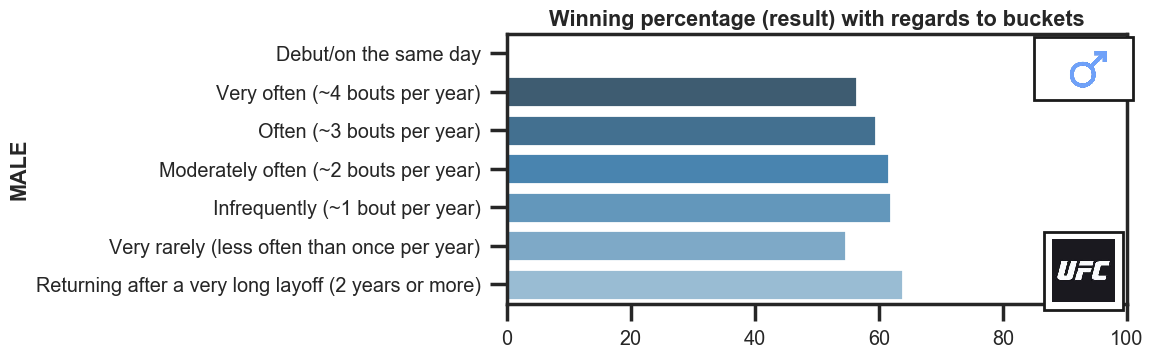

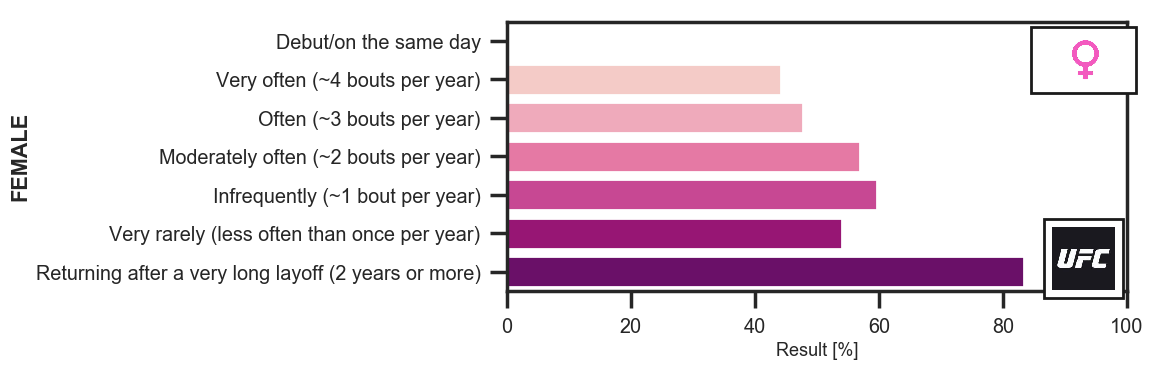

In [581]:
# Comparing charts for all fights recorded in the UFC (UFC roster) - gender separation.
sns.set_context('poster', font_scale = 0.65)

plt.figure(figsize=(8,3.5), dpi= 100)

ax1 = sns.barplot(male_true_pct.values, male_true_pct.index, palette="Blues_d")
ax1.set_xlim(0, 100)
ax1.set_ylabel('MALE', fontweight='heavy')

male_logo = mpimg.imread('male.png')
female_logo = mpimg.imread('female.jpg')

imagebox = OffsetImage(ufc_logo, zoom=0.25)
malebox = OffsetImage(male_logo, zoom=0.2)
ab = AnnotationBbox(imagebox, (93, 5.65))
ab_gen = AnnotationBbox(malebox, (93, 0.4))
ax1.add_artist(ab)
ax1.add_artist(ab_gen)

plt.figure(figsize=(8,3.5), dpi= 100)
ax2 = sns.barplot(female_true_pct, female_true_pct.index, palette="RdPu")
ax2.set_xlim(0, 100)
ax2.set_xlabel('Result [%]', fontsize='smaller')
ax2.set_ylabel('FEMALE', fontweight='heavy')

imagebox = OffsetImage(ufc_logo, zoom=0.25)
femalebox = OffsetImage(female_logo, zoom=0.075)
ab2 = AnnotationBbox(imagebox, (93, 5.65))
ab_gen2 = AnnotationBbox(femalebox, (93, 0.5))
ax2.add_artist(ab2)
ax2.add_artist(ab_gen2)

ax1.set_title('Winning percentage (result) with regards to buckets', fontweight='bold')
plt.show()

Analysing the UFC data separated by a gender enabled us to get more insight. I am wondering, if looking at the data in regards to weight divisions can provide even more useful information. Should a fighter's size determine how often he is able to fight without any negative impact on the result?

Proceeding further, we will set aside two edge buckets - ***'Debut/on the same day'*** and '***Returning after a very long layoff (2 years or more)***'. We have already analyzed data related to the mentioned buckets while on the topic of the UFC roster and the Sherdog database analysis. The amount of observations for these buckets became smaller and smaller with each additional constraint.

### HEAVYWEIGHT

In [582]:
# Assigning the heavyweight division object to a variable.
HW_div = weightclass_obj_list[0]

In [583]:
# Validation.
HW_div.name

'Heavyweight'

In [584]:
HW_div.all_fights_counts

Moderately often (~2 bouts per year)                    107
Infrequently (~1 bout per year)                         100
Often (~3 bouts per year)                                68
Very often (~4 bouts per year)                           35
Very rarely (less often than once per year)              26
Returning after a very long layoff (2 years or more)      5
Debut/on the same day                                     0
Name: Descriptive_interval, dtype: int64

In [585]:
# Assigning result (percentage ratio between amount of wins and total amount of wins and losses) to a variable.
HW_pct = HW_div.win_fights_counts / (HW_div.win_fights_counts + HW_div.loss_fights_counts)

In [586]:
# Sorting results in ascending order.
HW_pct_sorted = HW_pct.sort_values(ascending=False)

In [587]:
# Removing two boundary brackets in compliance with the analysis objective.
HW_pct_sorted = HW_pct_sorted.drop(labels=['Debut/on the same day', 
                                           'Returning after a very long layoff (2 years or more)'])

In [588]:
HW_pct_sorted

Moderately often (~2 bouts per year)           0.641509
Infrequently (~1 bout per year)                0.628866
Often (~3 bouts per year)                      0.590909
Very rarely (less often than once per year)    0.576923
Very often (~4 bouts per year)                 0.575758
Name: Descriptive_interval, dtype: float64

The outcome of the analysis for the UFC's heavyweight division with regards to buckets is essentially similar to the outcome of the analysis for all men. The Buckets with frequency ranging from 1 to 3 fights per year scored the highest results and the differences between them were minor. 

The two fringe buckets scored the lowest results which were about *7 percentage points* below the top results (similiar to what was observed in the analysis for all men).

### LIGHT HEAVYWEIGHT

In [589]:
# Assigning the light-heavyweight division object to a variable.
LHW_div = weightclass_obj_list[1]

In [590]:
# Validation.
LHW_div.name

'Light Heavyweight'

In [591]:
LHW_div.all_fights_counts

Infrequently (~1 bout per year)                         137
Moderately often (~2 bouts per year)                    131
Often (~3 bouts per year)                                60
Very often (~4 bouts per year)                           50
Very rarely (less often than once per year)              26
Returning after a very long layoff (2 years or more)      2
Debut/on the same day                                     0
Name: Descriptive_interval, dtype: int64

In [592]:
# Assigning result (percentage ratio between amount of wins and total amount of wins and losses) to a variable.
LHW_pct = LHW_div.win_fights_counts / (LHW_div.win_fights_counts + LHW_div.loss_fights_counts)

In [593]:
# Sorting results in ascending order.
LHW_pct_sorted = LHW_pct.sort_values(ascending=False)

In [594]:
# Removing two boundary buckets in compliance with the analysis objective.
LHW_pct_sorted = LHW_pct_sorted.drop(labels=['Debut/on the same day', 
                                           'Returning after a very long layoff (2 years or more)'])

In [595]:
LHW_pct_sorted

Very often (~4 bouts per year)                 0.640000
Very rarely (less often than once per year)    0.615385
Often (~3 bouts per year)                      0.600000
Moderately often (~2 bouts per year)           0.592308
Infrequently (~1 bout per year)                0.507463
Name: Descriptive_interval, dtype: float64

When it comes to the light heavyweight division, we can observe an inverted relationship. The two fringe intervals scored the highest results. The result for the buckets corresponding to 2-3 fights is not much lower, although, what immediately draws the attention is a statistically significant difference between the bucket representing frequency of 1 bout per year and the top category. **The difference reaches almost *14 percentage points***. It is worth noticing, that this cannot be explained by a small number of observations since this category has the highest amount of observations. Even if we limit ourselves to a comparison with the *'Moderately often (~2 bouts per year)'* bucket, which has almost the same number of observations, we are still getting approximately a *9 percentage point* difference.

### MIDDLEWEIGHT

In [596]:
# Assigning the middleweight division object to a variable.
MW_div = weightclass_obj_list[2]

In [597]:
# Validation.
MW_div.name

'Middleweight'

In [598]:
MW_div.all_fights_counts

Moderately often (~2 bouts per year)                    153
Infrequently (~1 bout per year)                         137
Often (~3 bouts per year)                                77
Very often (~4 bouts per year)                           59
Very rarely (less often than once per year)              34
Returning after a very long layoff (2 years or more)      3
Debut/on the same day                                     0
Name: Descriptive_interval, dtype: int64

In [599]:
# Assigning result (percentage ratio between amount of wins and total amount of wins and losses) to a variable.
MW_pct = MW_div.win_fights_counts / (MW_div.win_fights_counts + MW_div.loss_fights_counts)

In [600]:
# Sorting results in ascending order.
MW_pct_sorted = MW_pct.sort_values(ascending=False)

In [601]:
# Removing two boundary buckets in compliance with the analysis objective.
MW_pct_sorted = MW_pct_sorted.drop(labels=['Debut/on the same day', 
                                           'Returning after a very long layoff (2 years or more)'])

In [602]:
MW_pct_sorted

Moderately often (~2 bouts per year)           0.649007
Infrequently (~1 bout per year)                0.634328
Often (~3 bouts per year)                      0.565789
Very rarely (less often than once per year)    0.531250
Very often (~4 bouts per year)                 0.474576
Name: Descriptive_interval, dtype: float64

The middleweight division presents similar results to what was observed in the heavyweights. Two intervals which represent the frequency of 1 and 2 bouts per year are score the highest results. The main difference is observed in regards to the 3 bouts per year category. It has scored approximately *7 percentage points* lower result than the top categories. The middlweight division results seems to be a bit more dispersed than in the case of the heavyweights.

Fringe buckets score the lowest results. **It is worth noticing that the interval with the highest frequency of ~4 bouts per year scored an extremely low result - *47%***. This makes a over **17 percentage point difference** between the mentioned bucket and the top one.

### WELTERWEIGHT

In [603]:
# Assigning the light-heavyweight division object to a variable.
WW_div = weightclass_obj_list[3]

In [604]:
# Validation.
WW_div.name

'Welterweight'

In [605]:
WW_div.all_fights_counts

Moderately often (~2 bouts per year)                    300
Infrequently (~1 bout per year)                         279
Often (~3 bouts per year)                               140
Very often (~4 bouts per year)                          130
Very rarely (less often than once per year)              63
Returning after a very long layoff (2 years or more)      8
Debut/on the same day                                     1
Name: Descriptive_interval, dtype: int64

In [606]:
# Assigning the result (percentage ratio between amount of wins and total amount of wins and losses) to a variable.
WW_pct = WW_div.win_fights_counts / (WW_div.win_fights_counts + WW_div.loss_fights_counts)

In [607]:
# Sorting results in ascending order.
WW_pct_sorted = WW_pct.sort_values(ascending=False)

In [608]:
# Removing two boundary buckets in compliance with analysis objective.
WW_pct_sorted = WW_pct_sorted.drop(labels=['Debut/on the same day', 
                                           'Returning after a very long layoff (2 years or more)'])

In [609]:
WW_pct_sorted

Infrequently (~1 bout per year)                0.616487
Moderately often (~2 bouts per year)           0.606780
Very often (~4 bouts per year)                 0.606299
Often (~3 bouts per year)                      0.604317
Very rarely (less often than once per year)    0.587302
Name: Descriptive_interval, dtype: float64

The welterweight division is characterized by a very low dispersion in results. There is a less than *3 percentage points*
distinction between the top (*Infrequently (~1 bout per year)*) and the bottom (*Very rarely (less often than once per year)*) bucket. We can conclude that there is a correlation between fighting frequency and the results in the welterweight division.

### LIGHTWEIGHT

In [610]:
# Assigning the lightweight division object to a variable.
LW_div = weightclass_obj_list[4]

In [611]:
# Validation.
LW_div.name

'Lightweight'

In [612]:
LW_div.all_fights_counts

Moderately often (~2 bouts per year)                    285
Infrequently (~1 bout per year)                         266
Often (~3 bouts per year)                               148
Very often (~4 bouts per year)                          130
Very rarely (less often than once per year)              48
Returning after a very long layoff (2 years or more)     10
Debut/on the same day                                     0
Name: Descriptive_interval, dtype: int64

In [613]:
# Assigning the result (percentage ratio between amount of wins and total amount of wins and losses) to variable.
LW_pct = LW_div.win_fights_counts / (LW_div.win_fights_counts + LW_div.loss_fights_counts)

In [614]:
# Sorting results in ascending order.
LW_pct_sorted = LW_pct.sort_values(ascending=False)

In [615]:
# Removing two boundary buckets in compliance with analysis objective.
LW_pct_sorted = LW_pct_sorted.drop(labels=['Debut/on the same day', 
                                           'Returning after a very long layoff (2 years or more)'])

In [616]:
LW_pct_sorted

Very rarely (less often than once per year)    0.659574
Infrequently (~1 bout per year)                0.647287
Moderately often (~2 bouts per year)           0.607774
Often (~3 bouts per year)                      0.584507
Very often (~4 bouts per year)                 0.561538
Name: Descriptive_interval, dtype: float64

**There seems to be a very interesting correlation in the lightweight division - the lower the frequency the higher the result.**
The first top two categories are quite close to each other in regards to the result, then, every next bucket is at least *5 percentage points* below the top intervals. There is almost a *10 percentage point* difference between fighters that fought less often than once per year and these who did not wait longer than 90 days between fights.

### FEATHERWEIGHT

In [617]:
# Assigning the featherweight division object to a variable.
FW_div = weightclass_obj_list[5]

In [618]:
# Validation.
FW_div.name

'Featherweight'

In [619]:
FW_div.all_fights_counts

Moderately often (~2 bouts per year)                    174
Infrequently (~1 bout per year)                         156
Often (~3 bouts per year)                                62
Very often (~4 bouts per year)                           57
Very rarely (less often than once per year)              50
Returning after a very long layoff (2 years or more)      6
Debut/on the same day                                     0
Name: Descriptive_interval, dtype: int64

In [620]:
# Assigning the result (percentage ratio between amount of wins and total amount of wins and losses) to variable.
FW_pct = FW_div.win_fights_counts / (FW_div.win_fights_counts + FW_div.loss_fights_counts)

In [621]:
# Sorting results in ascending order.
FW_pct_sorted = LW_pct.sort_values(ascending=False)

In [622]:
# Removing two boundary buckets in compliance with analysis objective.
FW_pct_sorted = FW_pct_sorted.drop(labels=['Debut/on the same day', 
                                           'Returning after a very long layoff (2 years or more)'])

In [623]:
FW_pct_sorted

Very rarely (less often than once per year)    0.659574
Infrequently (~1 bout per year)                0.647287
Moderately often (~2 bouts per year)           0.607774
Often (~3 bouts per year)                      0.584507
Very often (~4 bouts per year)                 0.561538
Name: Descriptive_interval, dtype: float64

The analysis of the featherweight division confirms dependencies that were observed in the lightweight division. The lower the frequency the higher the result.
Once again, the lowest score belongs to the time interval that is related to the highest frequency. **The gap is almost *10 percentage points*.**

### BANTAMWEIGHT

In [624]:
# Assigning the bantamweight division object to a variable.
BW_div = weightclass_obj_list[6]

In [625]:
# Validation.
BW_div.name

'Bantamweight'

In [626]:
BW_div.all_fights_counts

Infrequently (~1 bout per year)                         157
Moderately often (~2 bouts per year)                    147
Often (~3 bouts per year)                                68
Very often (~4 bouts per year)                           59
Very rarely (less often than once per year)              34
Returning after a very long layoff (2 years or more)      5
Debut/on the same day                                     0
Name: Descriptive_interval, dtype: int64

In [627]:
# Assigning the result (percentage ratio between amount of wins and total amount of wins and losses) to variable.
BW_pct = BW_div.win_fights_counts / (BW_div.win_fights_counts + BW_div.loss_fights_counts)

In [628]:
# Sorting results in ascending order.
BW_pct_sorted = BW_pct.sort_values(ascending=False)

In [629]:
# Removing two boundary buckets in compliance with the analysis objective.
BW_pct_sorted = BW_pct_sorted.drop(labels=['Debut/on the same day', 
                                           'Returning after a very long layoff (2 years or more)'])

In [630]:
BW_pct_sorted

Often (~3 bouts per year)                      0.632353
Moderately often (~2 bouts per year)           0.631944
Infrequently (~1 bout per year)                0.606452
Very often (~4 bouts per year)                 0.593220
Very rarely (less often than once per year)    0.333333
Name: Descriptive_interval, dtype: float64

The highest result was scored by the interval labeled as *Often (~3 bouts per year)*. Buckets that describe the frequency of 1 and 4 bouts per year were also at the top, very close to one another. **The bucket representing the very low frequency scored the lowest result taking into account all inspected weight classes so far (*33%* of 34 observations).**

### FLYWEIGHT

In [631]:
# Assigning the flyweight division object to a variable.
FLW_div = weightclass_obj_list[7]

In [632]:
# Validation.
FLW_div.name

'Flyweight'

In [633]:
FLW_div.all_fights_counts

Infrequently (~1 bout per year)                         75
Moderately often (~2 bouts per year)                    68
Often (~3 bouts per year)                               29
Very often (~4 bouts per year)                          22
Very rarely (less often than once per year)             10
Returning after a very long layoff (2 years or more)     0
Debut/on the same day                                    0
Name: Descriptive_interval, dtype: int64

In [634]:
# Assigning result (percentage ratio between amount of wins and total amount of wins and losses) to a variable.
FLW_pct = FLW_div.win_fights_counts / (FLW_div.win_fights_counts + FLW_div.loss_fights_counts)

In [635]:
# Sorting results in ascending order.
FLW_pct_sorted = FLW_pct.sort_values(ascending=False)

In [636]:
# Removing two boundary buckets in compliance with the analysis objective.
FLW_pct_sorted = FLW_pct_sorted.drop(labels=['Debut/on the same day', 
                                           'Returning after a very long layoff (2 years or more)'])

In [637]:
FLW_pct_sorted

Infrequently (~1 bout per year)                0.680000
Moderately often (~2 bouts per year)           0.558824
Very often (~4 bouts per year)                 0.500000
Very rarely (less often than once per year)    0.444444
Often (~3 bouts per year)                      0.428571
Name: Descriptive_interval, dtype: float64

The flyweight division can be distinguished as a group with the lowest number of observations. We can notice that the data is way more dispersed and there are relatively big inequalities in the results. The buckets labeled as *Infrequently (~1 bout per year)* and *Moderately often (~2 bouts per year)* scored the highest outcomes.

### Visualizations of each male weight-class

In [638]:
# Removing two boundary buckets in compliance with the analysis objective.
male_pct_trunc = male_pct_sorted.drop(labels=['Debut/on the same day', 
                                           'Returning after a very long layoff (2 years or more)'])

In [639]:
male_pct_trunc

Infrequently (~1 bout per year)                0.619455
Moderately often (~2 bouts per year)           0.616012
Often (~3 bouts per year)                      0.594679
Very often (~4 bouts per year)                 0.564246
Very rarely (less often than once per year)    0.547368
Name: Descriptive_interval, dtype: float64

In [640]:
# Creating data frame objects for each division.
HW_frame = pd.DataFrame(dict(HEAVYWEIGHT = HW_pct_sorted, MALE = male_pct_trunc))
LHW_frame = pd.DataFrame(dict(LIGHT_HEAVYWEIGHT = LHW_pct_sorted, MALE = male_pct_trunc))
MW_frame = pd.DataFrame(dict(MIDDLEWEIGHT = MW_pct_sorted, MALE = male_pct_trunc))
WW_frame = pd.DataFrame(dict(WELTERWEIGHT = WW_pct_sorted, MALE = male_pct_trunc))
LW_frame = pd.DataFrame(dict(LIGHTWEIGHT = LW_pct_sorted, MALE = male_pct_trunc))
FW_frame = pd.DataFrame(dict(FEATHERWEIGHT = FW_pct_sorted, MALE = male_pct_trunc))
BW_frame = pd.DataFrame(dict(BANTAMWEIGHT = BW_pct_sorted, MALE = male_pct_trunc))
FLW_frame = pd.DataFrame(dict(FLYWEIGHT = FLW_pct_sorted, MALE = male_pct_trunc))

In [641]:
# Reindexing data frames in order to get neat visualization.
new_index = ['Very often (~4 bouts per year)', 'Often (~3 bouts per year)', 
             'Moderately often (~2 bouts per year)', 'Infrequently (~1 bout per year)',
             'Very rarely (less often than once per year)']

HW_frame = HW_frame.reindex(index=new_index)
LHW_frame = LHW_frame.reindex(index=new_index)
MW_frame = MW_frame.reindex(index=new_index)
WW_frame = WW_frame.reindex(index=new_index)
LW_frame = LW_frame.reindex(index=new_index)
FW_frame = FW_frame.reindex(index=new_index)
BW_frame = BW_frame.reindex(index=new_index)
FLW_frame = FLW_frame.reindex(index=new_index)

In [642]:
# Helper function that initiates plots that compare the weight class results to the gender results.
def create_div_barplot(div_frame, gender):
    '''
    args: DataFrame obj, 
          gender as string: F for female, or M for men
    '''
    plt.rcdefaults()
    if gender == 'M':
        with plt.style.context('seaborn'):
            plt.figure(figsize=(18, 9), dpi=100)
            ax = div_frame.plot(kind='bar', fontsize=13, ylim=(0, 1), color=['k', 'b'])

            imagebox = OffsetImage(ufc_logo, zoom=0.25)
            malebox = OffsetImage(male_logo, zoom=0.2)
            ab = AnnotationBbox(imagebox, (0, 0.91))
            ab_gen = AnnotationBbox(malebox, (0.75, 0.92))
            ax.add_artist(ab)
            ax.add_artist(ab_gen)

            plt.title('Winning fraction (result) with regards to buckets', fontweight='bold')
            plt.legend(frameon=True, shadow=True)
            plt.show()
    elif gender == 'F':
        with plt.style.context('seaborn'):
            plt.figure(figsize=(18, 9), dpi=100)
            ax = div_frame.plot(kind='bar', fontsize=13, ylim=(0, 1), color=['k', 'fuchsia'])

            imagebox = OffsetImage(ufc_logo, zoom=0.25)
            femalebox = OffsetImage(female_logo, zoom=0.071)
            ab = AnnotationBbox(imagebox, (0, 0.91))
            ab_gen = AnnotationBbox(femalebox, (0.75, 0.92))
            ax.add_artist(ab)
            ax.add_artist(ab_gen)

            plt.title('Winning fraction (result) with regards to buckets', fontweight='bold')
            plt.legend(frameon=True, shadow=True)
            plt.show()
    else:
        print('Gender was not specyfied in the function!')

<Figure size 1800x900 with 0 Axes>

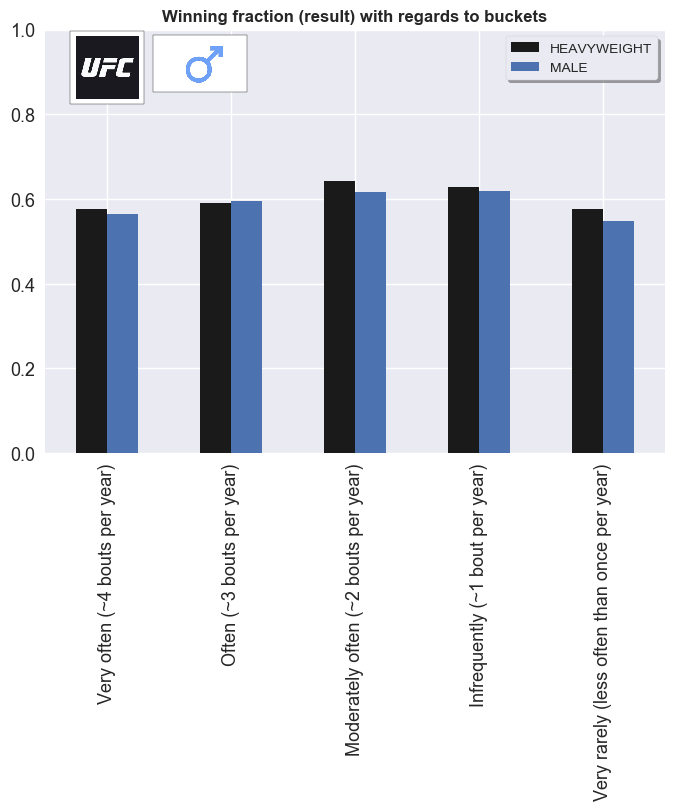

In [643]:
# Plot that compares the heavyweight division with UFC's male population with regards to the result.
create_div_barplot(HW_frame, 'M')

<Figure size 1800x900 with 0 Axes>

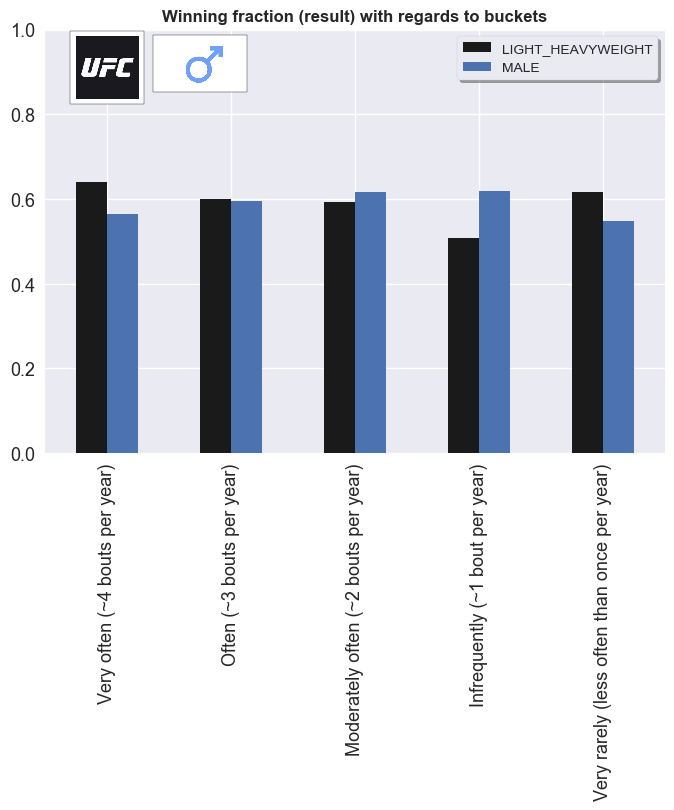

In [644]:
# Plot that compares the light-heavyweight division with UFC's male population with regards to the result.
create_div_barplot(LHW_frame, 'M')

<Figure size 1800x900 with 0 Axes>

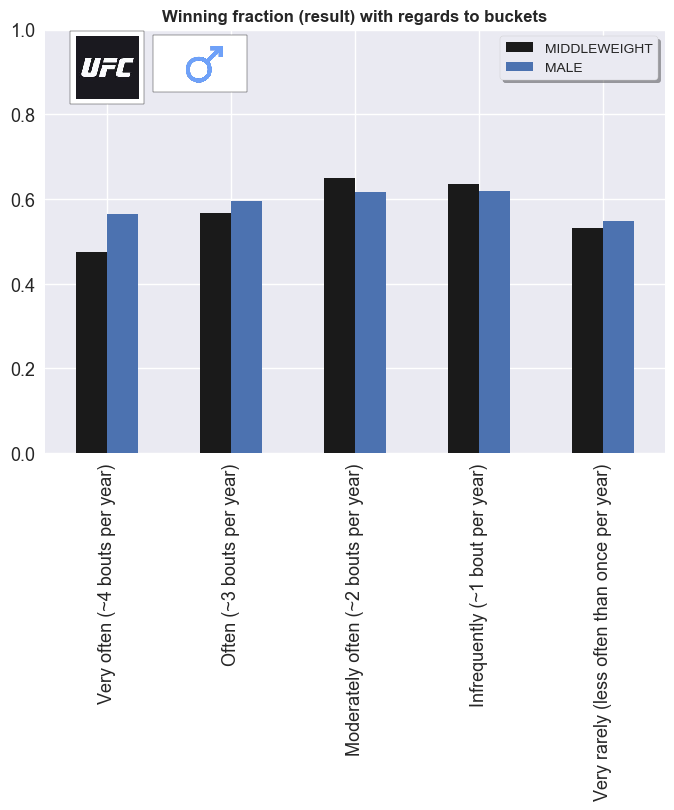

In [645]:
# Plot that compares the middleweight division with UFC's male population with regards to the result.
create_div_barplot(MW_frame, 'M')

<Figure size 1800x900 with 0 Axes>

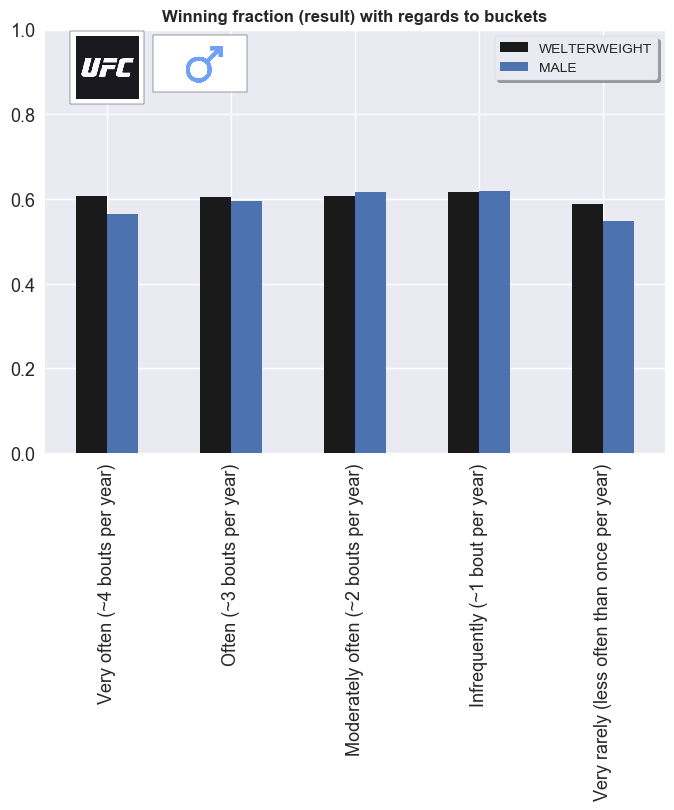

In [646]:
# Plot that compares the welterweight division with UFC's male population with regards to the result.
create_div_barplot(WW_frame, 'M')

<Figure size 1800x900 with 0 Axes>

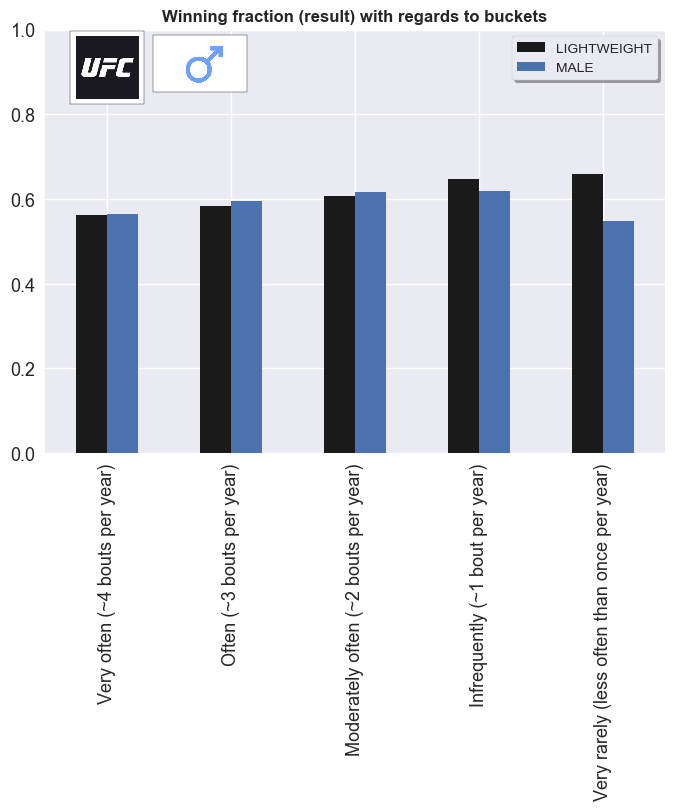

In [647]:
# Plot that compares the lightweight division with UFC's male population with regards to the result.
create_div_barplot(LW_frame, 'M')

<Figure size 1800x900 with 0 Axes>

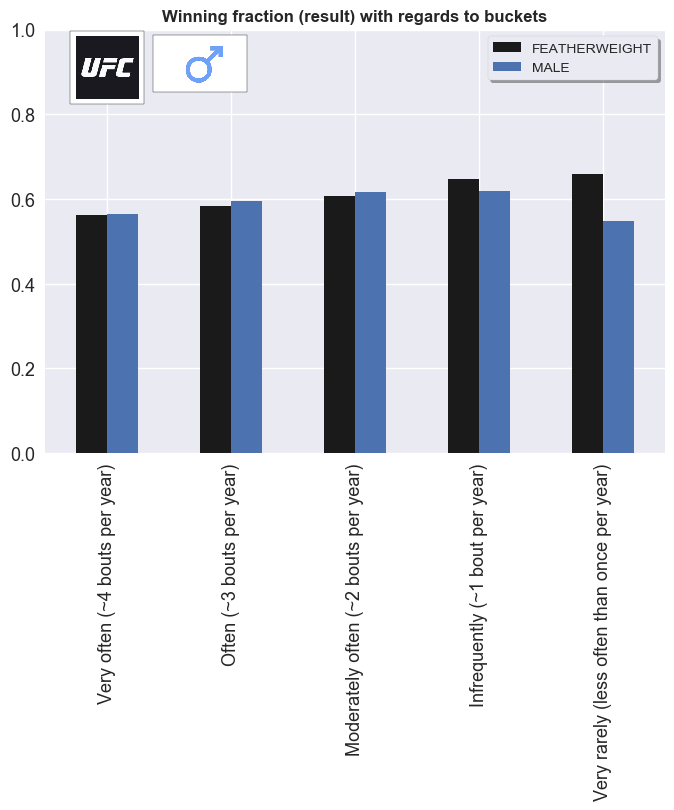

In [648]:
# Plot that compares the featherweight division with UFC's male population with regards to the result.
create_div_barplot(FW_frame, 'M')

<Figure size 1800x900 with 0 Axes>

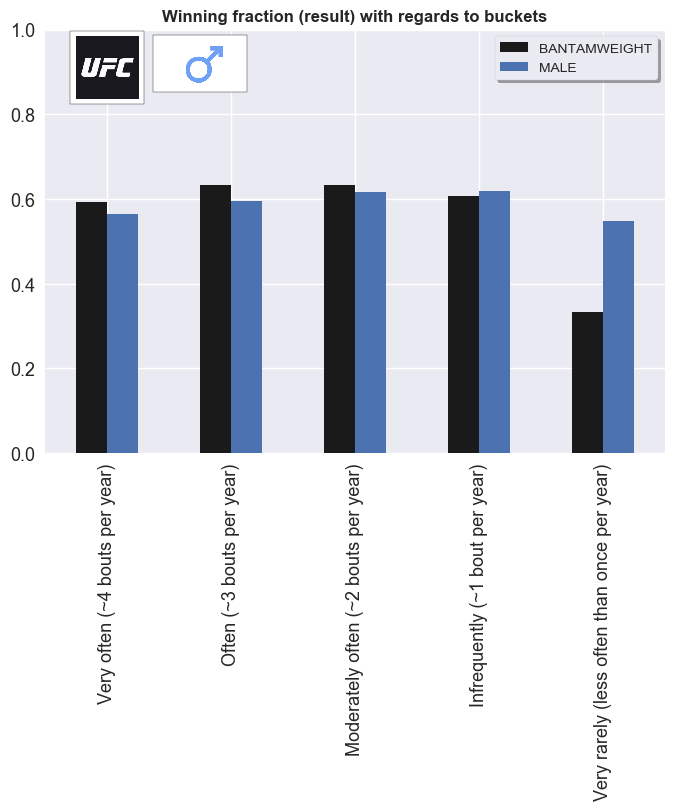

In [649]:
# Plot that compares the bantamweight division with UFC's male population with regards to the result.
create_div_barplot(BW_frame, 'M')

<Figure size 1800x900 with 0 Axes>

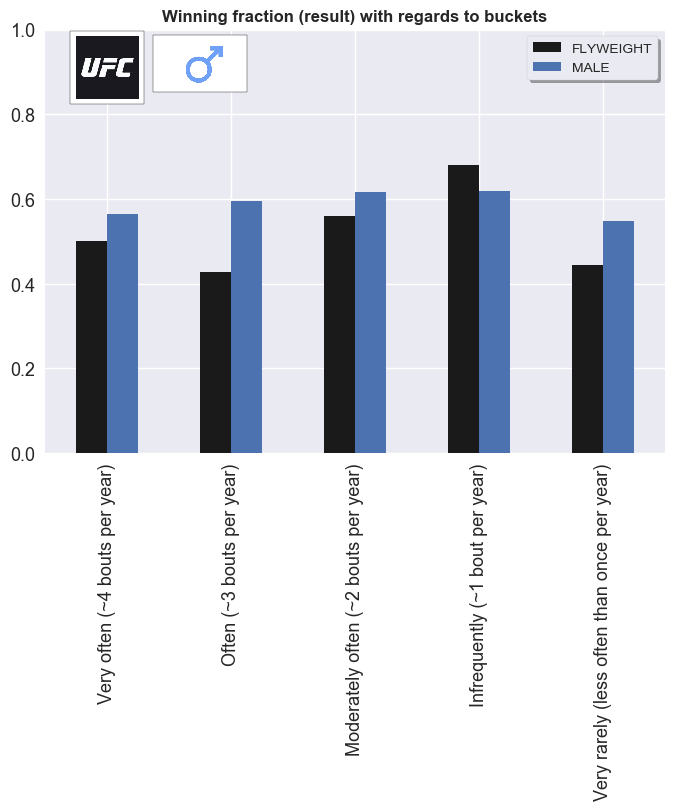

In [650]:
# Plot that compares the flyweight division with UFC's male population with regards to the result.
create_div_barplot(FLW_frame, 'M')

### WOMEN'S STRAWWEIGHT

In [651]:
# Assigning the women's strawweight division object to a variable.
WSW_div = weightclass_obj_list[8]

In [652]:
# Validation.
WSW_div.name

"Women's Strawweight"

In [653]:
WSW_div.all_fights_counts

Moderately often (~2 bouts per year)                    75
Infrequently (~1 bout per year)                         69
Often (~3 bouts per year)                               36
Very rarely (less often than once per year)             23
Very often (~4 bouts per year)                          20
Returning after a very long layoff (2 years or more)     3
Debut/on the same day                                    0
Name: Descriptive_interval, dtype: int64

In [654]:
# Assigning result (percentage ratio between amount of wins and total amount of wins and losses) to a variable.
WSW_pct = WSW_div.win_fights_counts / (WSW_div.win_fights_counts + WSW_div.loss_fights_counts)

In [655]:
# Sorting results in ascending order.
WSW_pct_sorted = WSW_pct.sort_values(ascending=False)

In [656]:
# Removing two boundary buckets in compliance with the analysis objective.
WSW_pct_sorted = WSW_pct_sorted.drop(labels=['Debut/on the same day', 
                                           'Returning after a very long layoff (2 years or more)'])

In [657]:
WSW_pct_sorted

Very rarely (less often than once per year)    0.652174
Moderately often (~2 bouts per year)           0.560000
Very often (~4 bouts per year)                 0.555556
Infrequently (~1 bout per year)                0.536232
Often (~3 bouts per year)                      0.500000
Name: Descriptive_interval, dtype: float64

The buckets representing very low frequencies scored the highest results by far (*almost 10 percentage points* above the second highest category). Further inequalities were not as significant and span between the second highest bucket and the one with the lowest result is only *6 percentage points*.

### WOMEN'S FLYWEIGHT

In [658]:
# Assigning the women's flyweight division object to a variable.
WFLW_div = weightclass_obj_list[9]

In [659]:
# Validation.
WFLW_div.name

"Women's Flyweight"

In [660]:
WFLW_div.all_fights_counts

Infrequently (~1 bout per year)                         64
Moderately often (~2 bouts per year)                    56
Often (~3 bouts per year)                               22
Very rarely (less often than once per year)             19
Very often (~4 bouts per year)                          12
Returning after a very long layoff (2 years or more)     1
Debut/on the same day                                    0
Name: Descriptive_interval, dtype: int64

In [661]:
# Assigning result (percentage ratio between amount of wins and total amount of wins and losses) to a variable.
WFLW_pct = WFLW_div.win_fights_counts / (WFLW_div.win_fights_counts + WFLW_div.loss_fights_counts)

In [662]:
# Sorting results in ascending order.
WFLW_pct_sorted = WFLW_pct.sort_values(ascending=False)

In [663]:
# Removing two boundary buckets in compliance with the analysis objective.
WFLW_pct_sorted = WFLW_pct_sorted.drop(labels=['Debut/on the same day', 
                                           'Returning after a very long layoff (2 years or more)'])

In [664]:
WFLW_pct_sorted

Infrequently (~1 bout per year)                0.625000
Very rarely (less often than once per year)    0.526316
Moderately often (~2 bouts per year)           0.509091
Often (~3 bouts per year)                      0.454545
Very often (~4 bouts per year)                 0.250000
Name: Descriptive_interval, dtype: float64

In the women's flyweight division, the bucket associated with the frequency of 1 bout per year scored the highest result (approximately *10 percentage points* higher than the second highest category). The two intervals representing the highest frequency scored the lowest results.
This coincides with the results of the entire women's population in the UFC.

### WOMEN'S BANTAMWEIGHT

In [665]:
# Assigning the women's bantamweight division object to a variable.
WBW_div = weightclass_obj_list[10]

In [666]:
# Validation.
WBW_div.name

"Women's Bantamweight"

In [667]:
WBW_div.all_fights_counts

Infrequently (~1 bout per year)                         56
Moderately often (~2 bouts per year)                    38
Very rarely (less often than once per year)             15
Very often (~4 bouts per year)                          11
Often (~3 bouts per year)                                9
Returning after a very long layoff (2 years or more)     2
Debut/on the same day                                    0
Name: Descriptive_interval, dtype: int64

In [668]:
# Assigning result (percentage ratio between amount of wins and total amount of wins and losses) to a variable.
WBW_pct = WBW_div.win_fights_counts / (WBW_div.win_fights_counts + WBW_div.loss_fights_counts)

In [669]:
# Sorting results in ascending order.
WBW_pct_sorted = WBW_pct.sort_values(ascending=False)

In [670]:
# Removing two boundary buckets in compliance with the analysis objective.
WBW_pct_sorted = WBW_pct_sorted.drop(labels=['Debut/on the same day', 
                                           'Returning after a very long layoff (2 years or more)'])

In [671]:
WBW_pct_sorted

Moderately often (~2 bouts per year)           0.675676
Infrequently (~1 bout per year)                0.625000
Very rarely (less often than once per year)    0.466667
Very often (~4 bouts per year)                 0.454545
Often (~3 bouts per year)                      0.375000
Name: Descriptive_interval, dtype: float64

The results of the women's bantamweight division are quite similar to what was observed during the analysis of the women's flyweight division. The two highest results are obtained by the low frequency intervals: *Moderately often (~2 bouts per year)* and *Infrequently (~1 bout per year)*, although the bucket representing a lower fight activity than once per year scored a significantly worse results than the top two intervals. Besides that, the lowest results were, again, connected to the higher fighting frequency.

### WOMEN'S FEATHERWEIGHT

In [672]:
# Assigning the women's featherweight division object to a variable.
WFW_div = weightclass_obj_list[11]

In [673]:
# Validation.
WFW_div.name

"Women's Featherweight"

In [674]:
WFW_div.all_fights_counts

Infrequently (~1 bout per year)                         7
Moderately often (~2 bouts per year)                    7
Very rarely (less often than once per year)             6
Very often (~4 bouts per year)                          2
Often (~3 bouts per year)                               1
Returning after a very long layoff (2 years or more)    0
Debut/on the same day                                   0
Name: Descriptive_interval, dtype: int64

In [675]:
# Assigning result (percentage ratio between amount of wins and total amount of wins and losses) to a variable.
WFW_pct = WFW_div.win_fights_counts / (WFW_div.win_fights_counts + WFW_div.loss_fights_counts)

In [676]:
# Sorting results in ascending order.
WFW_pct_sorted = WFW_pct.sort_values(ascending=False)

In [677]:
# Removing two boundary buckets in compliance with the analysis objective.
WFW_pct_sorted = WFW_pct_sorted.drop(labels=['Debut/on the same day', 
                                           'Returning after a very long layoff (2 years or more)'])

In [678]:
WFW_pct_sorted

Often (~3 bouts per year)                      1.000000
Infrequently (~1 bout per year)                0.714286
Moderately often (~2 bouts per year)           0.571429
Very often (~4 bouts per year)                 0.500000
Very rarely (less often than once per year)    0.333333
Name: Descriptive_interval, dtype: float64

Unfortunately, there is a fluctuation in the data due to the a very small amount of observations in the women's featherweight division.

### Visualizations of each female weight-class

In [679]:
# Removing two boundary buckets in compliance with the analysis objective.
female_pct_trunc = female_pct_sorted.drop(labels=['Debut/on the same day', 
                                           'Returning after a very long layoff (2 years or more)'])

In [680]:
female_pct_trunc

Infrequently (~1 bout per year)                0.596939
Moderately often (~2 bouts per year)           0.568966
Very rarely (less often than once per year)    0.539683
Often (~3 bouts per year)                      0.477612
Very often (~4 bouts per year)                 0.441860
Name: Descriptive_interval, dtype: float64

In [681]:
# Creating data frame objects for each division.
WSW_frame = pd.DataFrame(dict(STRAWWEIGHT = WSW_pct_sorted, FEMALE = female_pct_trunc))
WFLW_frame = pd.DataFrame(dict(FLYWEIGHT = WFLW_pct_sorted, FEMALE = female_pct_trunc))
WBW_frame = pd.DataFrame(dict(BANTAMWEIGHT = WBW_pct_sorted, FEMALE = female_pct_trunc))
WFW_frame = pd.DataFrame(dict(FEATHERWEIGHT = WFW_pct_sorted, FEMALE = female_pct_trunc))

In [682]:
# Reindexing data frames in order to get neat visualization.
new_index = ['Very often (~4 bouts per year)', 'Often (~3 bouts per year)', 
             'Moderately often (~2 bouts per year)', 'Infrequently (~1 bout per year)',
             'Very rarely (less often than once per year)']

WSW_frame = WSW_frame.reindex(index=new_index)
WFLW_frame = WFLW_frame.reindex(index=new_index)
WBW_frame = WBW_frame.reindex(index=new_index)
WFW_frame = WFW_frame.reindex(index=new_index)

<Figure size 1800x900 with 0 Axes>

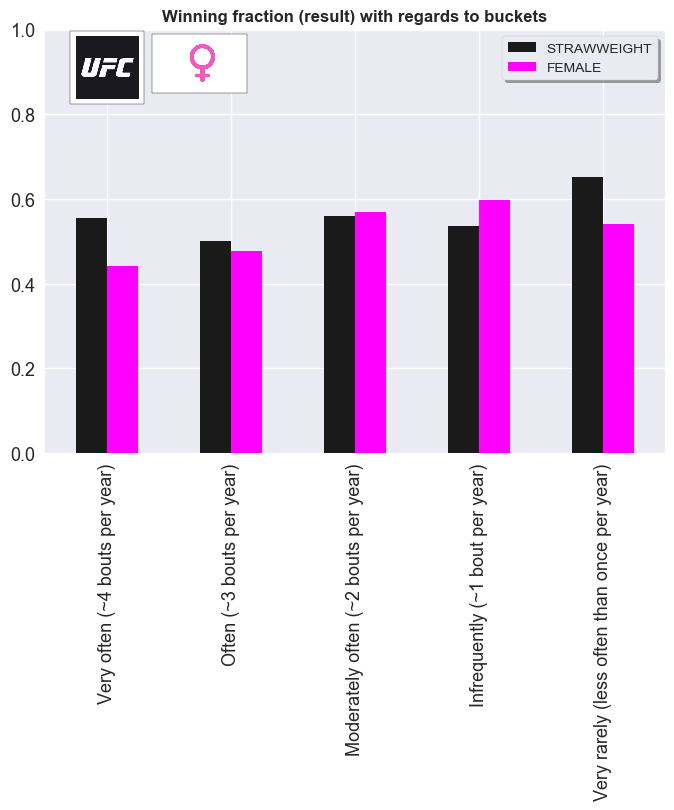

In [683]:
# Plot that compares the strawweight division with UFC's female population with regards to the result.
create_div_barplot(WSW_frame, 'F')

<Figure size 1800x900 with 0 Axes>

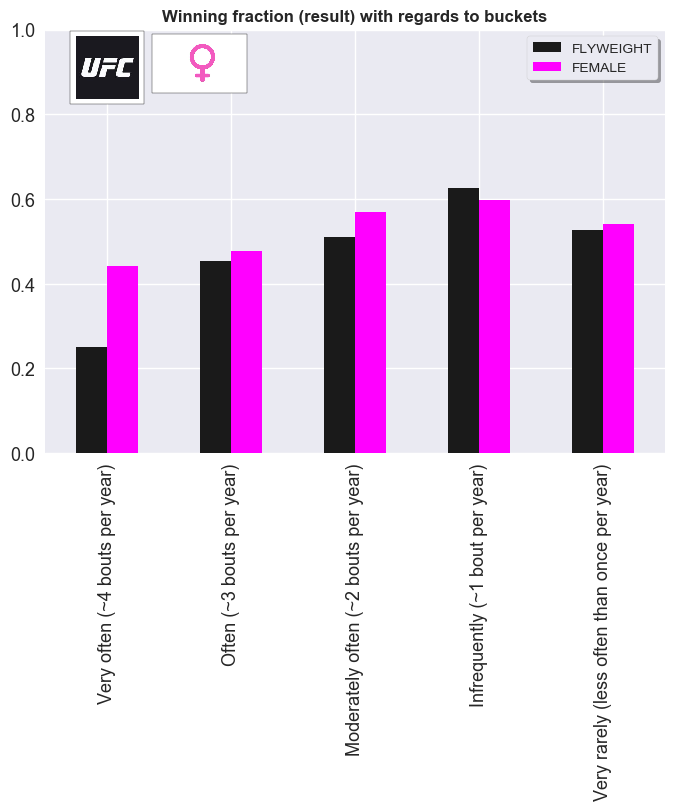

In [684]:
# Plot that compares flyweight division with UFC's female population with regards to the result.
create_div_barplot(WFLW_frame, 'F')

<Figure size 1800x900 with 0 Axes>

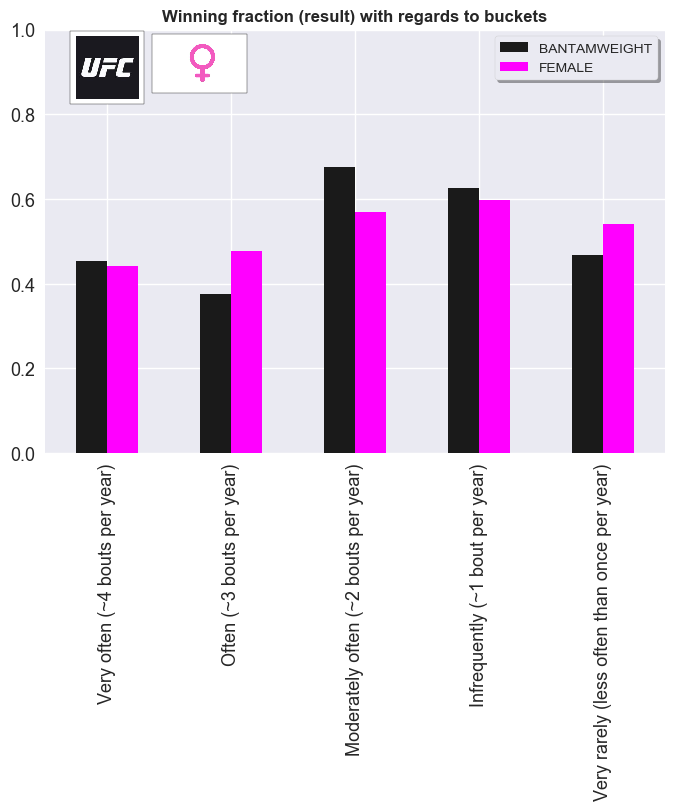

In [685]:
# Plot that compares bantamweight division with UFC's female population with regards to the result.
create_div_barplot(WBW_frame, 'F')

<Figure size 1800x900 with 0 Axes>

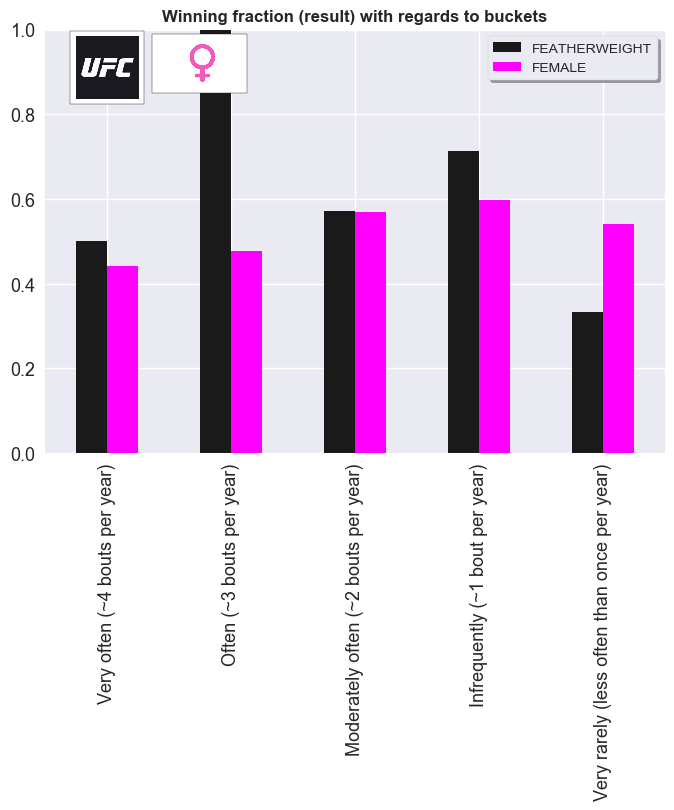

In [686]:
# Plot that compares feathwerweight division with UFC's female population with regards to the result.
create_div_barplot(WFW_frame, 'F')

## Segment 5: *The further analysis - taking special circumstances into account*

In the first part, we will try to verify a hypothesis: there is a correlation between the length of time off taken by a MMA fighter after a KO/TKO loss and his/her chances of winning the next bout.

The hypothesis will be either accepted or rejected based on the UFC's roster data analysis.

In [687]:
ufc_selected_data[0:10]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval
0,Shamil Abdurakhimov,loss,UFC 242 - Khabib vs. Poirier,2019-09-07,140,Moderately often (~2 bouts per year)
1,Shamil Abdurakhimov,win,UFC Fight Night 149 - Overeem vs. Oleynik,2019-04-20,217,Infrequently (~1 bout per year)
2,Shamil Abdurakhimov,win,UFC Fight Night 136 - Hunt vs. Oleynik,2018-09-15,294,Infrequently (~1 bout per year)
3,Shamil Abdurakhimov,win,UFC Fight Night 122 - Bisping vs. Gastelum,2017-11-25,351,Infrequently (~1 bout per year)
4,Shamil Abdurakhimov,loss,UFC Fight Night 102 - Lewis vs. Abdurakhimov,2016-12-09,69,Very often (~4 bouts per year)
5,Shamil Abdurakhimov,win,UFC Fight Night 96 - Lineker vs. Dodson,2016-10-01,223,Infrequently (~1 bout per year)
6,Shamil Abdurakhimov,win,UFC Fight Night 83 - Cerrone vs. Oliveira,2016-02-21,323,Infrequently (~1 bout per year)
7,Shamil Abdurakhimov,loss,UFC Fight Night 63 - Mendes vs. Lamas,2015-04-04,301,Infrequently (~1 bout per year)
8,Shamil Abdurakhimov,win,M-1 Challenge 49 - Battle in the Mountains,2014-06-07,246,Infrequently (~1 bout per year)
9,Shamil Abdurakhimov,win,Tech-Krep FC - Southern Front 2,2013-10-04,551,Very rarely (less often than once per year)


In [688]:
ufc_data[0:10]

,Fighter,Opponent,Result,Event,Event_date,Method,Referee,Round,Time
0,Shamil Abdurakhimov,Curtis Blaydes,loss,UFC 242 - Khabib vs. Poirier,Sep / 07 / 2019,TKO (Elbow and Punch),Marc Goddard,2,02:22
1,Shamil Abdurakhimov,Marcin Tybura,win,UFC Fight Night 149 - Overeem vs. Oleynik,Apr / 20 / 2019,TKO (Punches),Herb Dean,2,03:15
2,Shamil Abdurakhimov,Andrei Arlovski,win,UFC Fight Night 136 - Hunt vs. Oleynik,Sep / 15 / 2018,Decision (Unanimous),Leon Roberts,3,05:00
3,Shamil Abdurakhimov,Chase Sherman,win,UFC Fight Night 122 - Bisping vs. Gastelum,Nov / 25 / 2017,KO (Punches),Steve Perceval,1,01:24
4,Shamil Abdurakhimov,Derrick Lewis,loss,UFC Fight Night 102 - Lewis vs. Abdurakhimov,Dec / 09 / 2016,TKO (Punches),Dan Miragliotta,4,03:42
5,Shamil Abdurakhimov,Walt Harris,win,UFC Fight Night 96 - Lineker vs. Dodson,Oct / 01 / 2016,Decision (Split),Herb Dean,3,05:00
6,Shamil Abdurakhimov,Anthony Hamilton,win,UFC Fight Night 83 - Cerrone vs. Oliveira,Feb / 21 / 2016,Decision (Unanimous),Chip Snider,3,05:00
7,Shamil Abdurakhimov,Timothy Johnson,loss,UFC Fight Night 63 - Mendes vs. Lamas,Apr / 04 / 2015,TKO (Punches),Mike King,1,04:57
8,Shamil Abdurakhimov,Kenny Garner,win,M-1 Challenge 49 - Battle in the Mountains,Jun / 07 / 2014,Decision (Unanimous),Viktor Korneev,3,05:00
9,Shamil Abdurakhimov,Neil Grove,win,Tech-Krep FC - Southern Front 2,Oct / 04 / 2013,Decision (Unanimous),Ashot Ashughyan,3,05:00


In [689]:
# Creating a new variable where we store the UFC's roster data frame.
ufc_extra_data = ufc_selected_data.copy()

In [690]:
# Adding two necessary columns.
ufc_extra_data['Method'] = ufc_data['Method']
ufc_extra_data['Round'] = ufc_data['Round']

In [691]:
ufc_extra_data[0:10]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval,Method,Round
0,Shamil Abdurakhimov,loss,UFC 242 - Khabib vs. Poirier,2019-09-07,140,Moderately often (~2 bouts per year),TKO (Elbow and Punch),2
1,Shamil Abdurakhimov,win,UFC Fight Night 149 - Overeem vs. Oleynik,2019-04-20,217,Infrequently (~1 bout per year),TKO (Punches),2
2,Shamil Abdurakhimov,win,UFC Fight Night 136 - Hunt vs. Oleynik,2018-09-15,294,Infrequently (~1 bout per year),Decision (Unanimous),3
3,Shamil Abdurakhimov,win,UFC Fight Night 122 - Bisping vs. Gastelum,2017-11-25,351,Infrequently (~1 bout per year),KO (Punches),1
4,Shamil Abdurakhimov,loss,UFC Fight Night 102 - Lewis vs. Abdurakhimov,2016-12-09,69,Very often (~4 bouts per year),TKO (Punches),4
5,Shamil Abdurakhimov,win,UFC Fight Night 96 - Lineker vs. Dodson,2016-10-01,223,Infrequently (~1 bout per year),Decision (Split),3
6,Shamil Abdurakhimov,win,UFC Fight Night 83 - Cerrone vs. Oliveira,2016-02-21,323,Infrequently (~1 bout per year),Decision (Unanimous),3
7,Shamil Abdurakhimov,loss,UFC Fight Night 63 - Mendes vs. Lamas,2015-04-04,301,Infrequently (~1 bout per year),TKO (Punches),1
8,Shamil Abdurakhimov,win,M-1 Challenge 49 - Battle in the Mountains,2014-06-07,246,Infrequently (~1 bout per year),Decision (Unanimous),3
9,Shamil Abdurakhimov,win,Tech-Krep FC - Southern Front 2,2013-10-04,551,Very rarely (less often than once per year),Decision (Unanimous),3


In [692]:
# Applying a mask in order to filter through the records that are meeting new analysis constraints. 
# Assigning the outcome to a variable.
ufc_after_ko = ufc_extra_data[(ufc_extra_data['Result'].shift(-1) == 'loss') & 
                              (ufc_extra_data['Method'].shift(-1).str.contains('KO')) & 
                              (ufc_extra_data['Fighter'] == ufc_extra_data['Fighter'].shift(-1))].copy()

In [693]:
ufc_after_ko[0:10]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval,Method,Round
3,Shamil Abdurakhimov,win,UFC Fight Night 122 - Bisping vs. Gastelum,2017-11-25,351,Infrequently (~1 bout per year),KO (Punches),1
6,Shamil Abdurakhimov,win,UFC Fight Night 83 - Cerrone vs. Oliveira,2016-02-21,323,Infrequently (~1 bout per year),Decision (Unanimous),3
33,Klidson Abreu,win,JF - Jungle Fight 90,2016-09-03,105,Often (~3 bouts per year),TKO (Doctor Stoppage),3
36,Klidson Abreu,win,SFC 1 - Sierra Fighting Championship 1,2015-08-22,252,Infrequently (~1 bout per year),TKO (Punches),1
78,Kevin Aguilar,win,LFC 39 - Legacy Fighting Championship 39,2015-02-27,448,Very rarely (less often than once per year),TKO (Punches),3
92,Omari Akhmedov,win,UFC Fight Night 101 - Whittaker vs. Brunson,2016-11-26,224,Infrequently (~1 bout per year),Decision (Unanimous),3
93,Omari Akhmedov,loss,UFC on Fox 19 - Teixeira vs. Evans,2016-04-16,128,Moderately often (~2 bouts per year),TKO (Knees and Punches),3
122,Heili Alateng,win,Road FC 46 - Road Fighting Championship 46,2018-03-10,364,Infrequently (~1 bout per year),TKO (Punches),1
134,Heili Alateng,loss,CKFC - Chinese Kung Fu Championships,2014-12-23,37,Very often (~4 bouts per year),Decision (Unanimous),3
136,Heili Alateng,win,CKFC - Chinese Kung Fu Championships,2014-11-11,157,Moderately often (~2 bouts per year),Submission (Rear-Naked Choke),2


In [694]:
# Assigning 'Descriptive_interval' column to a variable.
ufc_ko_brackets = ufc_after_ko['Descriptive_interval']

In [695]:
# Creating variables where interval data is assigned based on the type of fight outcome.
ufc_ako_all_fights_count = ufc_ko_brackets.value_counts()
ufc_ako_win_fights_count = ufc_ko_brackets[ufc_after_ko['Result'] == 'win'].value_counts()
ufc_ako_loss_fights_count = ufc_ko_brackets[ufc_after_ko['Result'] == 'loss'].value_counts()
ufc_ako_draw_fights_count = ufc_ko_brackets[ufc_after_ko['Result'] == 'draw'].value_counts()
ufc_ako_nc_fights_count = ufc_ko_brackets[ufc_after_ko['Result'] == 'NC'].value_counts()

In [696]:
ufc_ako_all_fights_count

Infrequently (~1 bout per year)                         268
Moderately often (~2 bouts per year)                    208
Very often (~4 bouts per year)                           84
Often (~3 bouts per year)                                70
Very rarely (less often than once per year)              69
Returning after a very long layoff (2 years or more)     16
Debut/on the same day                                     0
Name: Descriptive_interval, dtype: int64

In [697]:
# Checking if there are any missing values in the 'Descriptive_interval' column.
ufc_after_ko[ufc_after_ko['Descriptive_interval'].isna()]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval,Method,Round


In [698]:
# Data validation - checking if there is any record that was not qualified as either a win, loss, draw or no-contest.
ufc_ako_sum_of_brackets = (ufc_ako_win_fights_count.sum() + ufc_ako_loss_fights_count.sum() + 
ufc_ako_draw_fights_count.sum() + ufc_ako_nc_fights_count.sum())

if ufc_ako_all_fights_count.sum() == ufc_ako_sum_of_brackets:
    print('Verification successful!')

Verification successful!


In [699]:
# Assigning result (percentage ratio between amount of wins and total amount of wins and losses) to a variable.
ufc_ako_pct = ufc_ako_win_fights_count/(ufc_ako_win_fights_count + ufc_ako_loss_fights_count)

In [700]:
# Sorting results in ascending order.
ufc_ako_sorted = ufc_ako_pct.sort_values(ascending=False)

In [701]:
# Removing debut bucket in compliance with analysis objective - obviously, fighting after a KO loss is not possible in 
# the debut.
ufc_ako_sorted = ufc_ako_sorted.drop(labels=['Debut/on the same day'])

In [702]:
ufc_ako_sorted

Returning after a very long layoff (2 years or more)    0.933333
Often (~3 bouts per year)                               0.800000
Very often (~4 bouts per year)                          0.746988
Very rarely (less often than once per year)             0.705882
Infrequently (~1 bout per year)                         0.642586
Moderately often (~2 bouts per year)                    0.640394
Name: Descriptive_interval, dtype: float64

In [703]:
# Removing debut bucket from the UFC roster data in order to visualize data together with the 'after_ko' data.
ufc_pct_trunc = ufc_pct_sorted.drop(labels=['Debut/on the same day'])

In [704]:
# Creating new data frame.
ufc_ako_frame = pd.DataFrame(dict(AFTER_KO_LOSS = ufc_ako_sorted, UFC_ROSTER = ufc_pct_trunc))

In [705]:
# Reindexing data frames in order to get neat visualization.
rep_index = ['Very often (~4 bouts per year)', 'Often (~3 bouts per year)', 
             'Moderately often (~2 bouts per year)', 'Infrequently (~1 bout per year)',
             'Very rarely (less often than once per year)', 'Returning after a very long layoff (2 years or more)']

ufc_ako_frame = ufc_ako_frame.reindex(index=rep_index)

In [706]:
ufc_ako_frame

,AFTER_KO_LOSS,UFC_ROSTER
Very often (~4 bouts per year),0.746988,0.800858
Often (~3 bouts per year),0.800000,0.742574
Moderately often (~2 bouts per year),0.640394,0.734148
Infrequently (~1 bout per year),0.642586,0.722242
Very rarely (less often than once per year),0.705882,0.703540
Returning after a very long layoff (2 years or more),0.933333,0.830357


In [707]:
# Helper function that initiates plots that compare UFC roster results to data related to the special circumstances.
def create_occ_barplot(frame, dataset, colors):
    '''
    args: DataFrame obj,
          dataset as string: ufc or sherdog
          colors as a list of strings (len=2)
    '''
    plt.rcdefaults()
    with plt.style.context('seaborn'):
            
            if dataset == 'ufc':
                plt.figure(figsize=(18, 9), dpi=100)
                ax = frame.plot(kind='bar', fontsize=13, ylim=(0, 1), color=[colors[0], colors[1]])
                imagebox = OffsetImage(ufc_logo, zoom=0.23)
                ab = AnnotationBbox(imagebox, (0, 0.91))
                ax.add_artist(ab)
            elif dataset == 'sherdog':
                plt.figure(figsize=(18, 9), dpi=100)
                ax = frame.plot(kind='bar', fontsize=13, ylim=(0, 1), color=[colors[0], colors[1]])
                imagebox = OffsetImage(sher_logo, zoom=0.3)
                ab = AnnotationBbox(imagebox, (0.15, 0.91))
                ax.add_artist(ab)
            

            plt.title('Winning fraction (result) with regards to buckets', fontweight='bold')
            plt.legend(frameon=True, shadow=True, loc=9)
            plt.show()

<Figure size 1800x900 with 0 Axes>

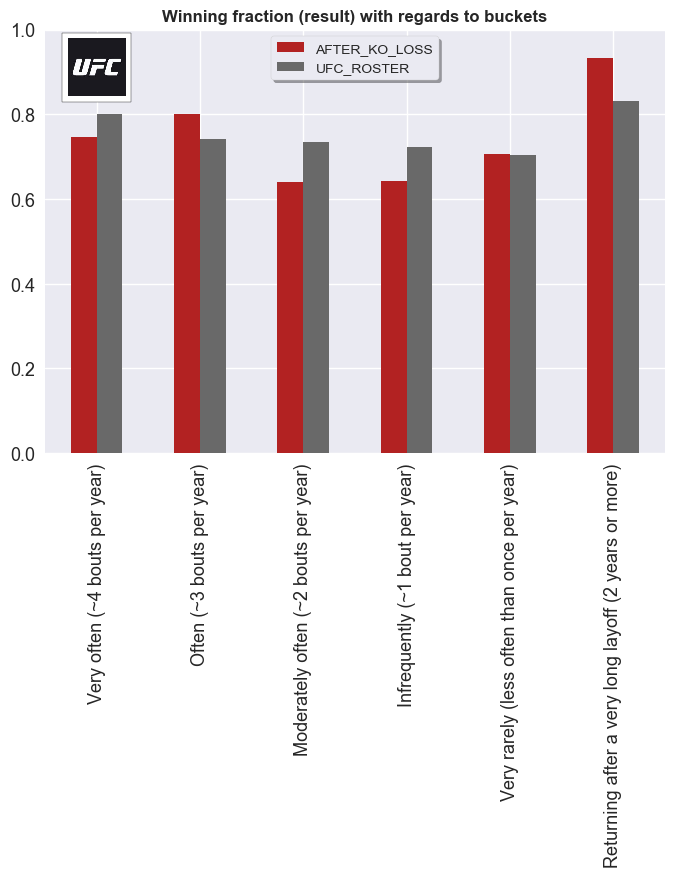

In [708]:
create_occ_barplot(ufc_ako_frame, 'ufc', ['firebrick', 'dimgrey'])

**The analysis did not confirm the hypothesis** - as we can see, the categories: *Very often (~4 bouts per year)*, *Moderately often (~2 bouts per year)* and *Infrequently (~1 bout per year)* with regards to fighters which came back after a KO/TKO loss, scored indeed lower results (reaching an almost *10 percentage point* difference), although this was not the case for the bucket labeled as *Often (~3 bouts per year)*. There is an inverse relationship and fighters that came back after a KO/TKO loss in the range of this particular interval scored a *6 percentage point* higher result than the whole UFC roster. The same relationship can be observed with the category *Returning after a very long layoff (2 years or more)*. The result there was almost *10 percentage points* higher than for the whole UFC roster.

For the bucket representing a frequency of 1 bout per year, the outcome matched the UFC's roster result.

Some categories were represented by a small amount of observations. The next step will include applying the same analysis to Sherdog's database.

In [709]:
sherdog_selected_data[0:10]

,Fighter,Result,Event_date,Time_interval,Descriptive_interval
0,Tony Galindo,loss,2005-03-20,758,Returning after a very long layoff (2 years or...
1,Tony Galindo,loss,2003-02-21,530,Very rarely (less often than once per year)
2,Tony Galindo,loss,2001-09-09,78,Very often (~4 bouts per year)
3,Tony Galindo,win,2001-06-23,119,Often (~3 bouts per year)
4,Tony Galindo,draw,2001-02-24,87,Very often (~4 bouts per year)
5,Tony Galindo,win,2000-11-29,158,Moderately often (~2 bouts per year)
6,Tony Galindo,win,2000-06-24,0,Debut/on the same day
7,Kurt Rojo,loss,2000-12-09,168,Moderately often (~2 bouts per year)
8,Kurt Rojo,loss,2000-06-24,0,Debut/on the same day
9,Brian Hawkins,loss,2006-03-18,1121,Returning after a very long layoff (2 years or...


In [710]:
sherdog_data[0:10]

,Fighter,Opponent,Result,Event,Event_date,Method,Referee,Round,Time;
0,Tony Galindo,Tony Lopez,loss,KOTC 49 Soboba,Mar / 20 / 2005,KO (Punches),NaN,1,3:24;
1,Tony Galindo,Joey Villasenor,loss,KOTC 21 Invasion,Feb / 21 / 2003,TKO (Corner Stoppage),Larry Landless,1,5:00;
2,Tony Galindo,Brian Sleeman,loss,GC 6 Caged Beasts,Sep / 09 / 2001,TKO (Corner Stoppage),Larry Landless,2,3:10;
3,Tony Galindo,Reggie Cardiel,win,KOTC 9 Showtime,Jun / 23 / 2001,Decision,NaN,2,5:00;
4,Tony Galindo,Reggie Cardiel,draw,KOTC 7 Wet and Wild,Feb / 24 / 2001,Draw,NaN,2,5:00;
5,Tony Galindo,Brian Hawkins,win,KOTC 6 Road Warriors,Nov / 29 / 2000,TKO (Punches),NaN,1,1:30;
6,Tony Galindo,Kurt Rojo,win,KOTC 4 Gladiators,Jun / 24 / 2000,KO (Punch),NaN,1,0:07;
7,Kurt Rojo,Phillip Miller,loss,GC 1 Gladiator Challenge 1,Dec / 09 / 2000,Decision,NaN,3,5:00;
8,Kurt Rojo,Tony Galindo,loss,KOTC 4 Gladiators,Jun / 24 / 2000,KO (Punch),NaN,1,0:07;
9,Brian Hawkins,James Lee,loss,KOTC Drop Zone,Mar / 18 / 2006,Submission (Heel Hook),NaN,1,0:24;


In [711]:
# Creating a new variable that will store copy of Sherdog's dataframe.
sherdog_extra_data = sherdog_selected_data.copy()

In [712]:
# Adding two necessary columns.
sherdog_extra_data['Method'] = sherdog_data['Method']
sherdog_extra_data['Round'] = sherdog_data['Round']

In [713]:
sherdog_extra_data[0:10]

,Fighter,Result,Event_date,Time_interval,Descriptive_interval,Method,Round
0,Tony Galindo,loss,2005-03-20,758,Returning after a very long layoff (2 years or...,KO (Punches),1
1,Tony Galindo,loss,2003-02-21,530,Very rarely (less often than once per year),TKO (Corner Stoppage),1
2,Tony Galindo,loss,2001-09-09,78,Very often (~4 bouts per year),TKO (Corner Stoppage),2
3,Tony Galindo,win,2001-06-23,119,Often (~3 bouts per year),Decision,2
4,Tony Galindo,draw,2001-02-24,87,Very often (~4 bouts per year),Draw,2
5,Tony Galindo,win,2000-11-29,158,Moderately often (~2 bouts per year),TKO (Punches),1
6,Tony Galindo,win,2000-06-24,0,Debut/on the same day,KO (Punch),1
7,Kurt Rojo,loss,2000-12-09,168,Moderately often (~2 bouts per year),Decision,3
8,Kurt Rojo,loss,2000-06-24,0,Debut/on the same day,KO (Punch),1
9,Brian Hawkins,loss,2006-03-18,1121,Returning after a very long layoff (2 years or...,Submission (Heel Hook),1


In [714]:
# Applying a mask in order to filter through records that are meeting the new analysis constraint.
sherdog_after_ko = sherdog_extra_data[(sherdog_extra_data['Result'].shift(-1) == 'loss') & 
                              (sherdog_extra_data['Method'].shift(-1).str.contains('KO')) & 
                              (sherdog_extra_data['Fighter'] == sherdog_extra_data['Fighter'].shift(-1))].copy()

In [715]:
sherdog_after_ko[0:10]

,Fighter,Result,Event_date,Time_interval,Descriptive_interval,Method,Round
0,Tony Galindo,loss,2005-03-20,758,Returning after a very long layoff (2 years or...,KO (Punches),1
1,Tony Galindo,loss,2003-02-21,530,Very rarely (less often than once per year),TKO (Corner Stoppage),1
7,Kurt Rojo,loss,2000-12-09,168,Moderately often (~2 bouts per year),Decision,3
9,Brian Hawkins,loss,2006-03-18,1121,Returning after a very long layoff (2 years or...,Submission (Heel Hook),1
13,Brian Hawkins,win,2002-05-17,56,Very often (~4 bouts per year),KO,1
14,Brian Hawkins,loss,2002-03-22,478,Very rarely (less often than once per year),KO (Punches),1
18,Ken Shamrock,loss,2016-02-19,245,Infrequently (~1 bout per year),TKO (Knee and Punches),1
19,Ken Shamrock,loss,2015-06-19,1667,Returning after a very long layoff (2 years or...,TKO (Punches),1
21,Ken Shamrock,win,2010-10-16,90,Very often (~4 bouts per year),Decision (Unanimous),3
23,Ken Shamrock,win,2009-02-13,342,Infrequently (~1 bout per year),Submission (Armbar),1


In [716]:
# Assigning the 'Descriptive_interval' column to a variable.
sherdog_ko_brackets = sherdog_after_ko['Descriptive_interval']

In [717]:
# Creating variables where interval data is assigned based on type of fight outcome.
sherdog_ako_all_fights_count = sherdog_ko_brackets.value_counts()
sherdog_ako_win_fights_count = sherdog_ko_brackets[sherdog_after_ko['Result'] == 'win'].value_counts()
sherdog_ako_loss_fights_count = sherdog_ko_brackets[sherdog_after_ko['Result'] == 'loss'].value_counts()
sherdog_ako_draw_fights_count = sherdog_ko_brackets[sherdog_after_ko['Result'] == 'draw'].value_counts()
sherdog_ako_nc_fights_count = sherdog_ko_brackets[sherdog_after_ko['Result'] == 'NC'].value_counts()

In [718]:
sherdog_ako_all_fights_count

Very often (~4 bouts per year)                          14987
Infrequently (~1 bout per year)                         12064
Moderately often (~2 bouts per year)                     8686
Very rarely (less often than once per year)              6929
Often (~3 bouts per year)                                5731
Returning after a very long layoff (2 years or more)     4518
Debut/on the same day                                     193
Name: Descriptive_interval, dtype: int64

In [719]:
# Checking if there are any missing values in the 'Descriptive_interval' column.
sherdog_after_ko[sherdog_after_ko['Descriptive_interval'].isna()]

,Fighter,Result,Event_date,Time_interval,Descriptive_interval,Method,Round


In [720]:
# Data validation - checking if there is any record that was not qualified as either win, loss, draw or no-contest.
sherdog_ako_sum_of_brackets = (sherdog_ako_win_fights_count.sum() + sherdog_ako_loss_fights_count.sum() + 
sherdog_ako_draw_fights_count.sum() + sherdog_ako_nc_fights_count.sum())

if sherdog_ako_all_fights_count.sum() == sherdog_ako_sum_of_brackets:
    print('Verification successful!')

Verification successful!


In [721]:
# Assigning result (percentage ratio between amount of wins and total amount of wins and losses) to a variable.
sherdog_ako_pct = sherdog_ako_win_fights_count/(sherdog_ako_win_fights_count + sherdog_ako_loss_fights_count)

In [722]:
# Sorting results in ascending order.
sherdog_ako_sorted = sherdog_ako_pct.sort_values(ascending=False)

In [723]:
sherdog_ako_sorted

Moderately often (~2 bouts per year)                    0.452715
Often (~3 bouts per year)                               0.437222
Infrequently (~1 bout per year)                         0.435099
Very rarely (less often than once per year)             0.423287
Very often (~4 bouts per year)                          0.396569
Returning after a very long layoff (2 years or more)    0.390277
Debut/on the same day                                   0.331606
Name: Descriptive_interval, dtype: float64

In [724]:
# Creating new data frame.
sherdog_ako_frame = pd.DataFrame(dict(AFTER_KO_LOSS = sherdog_ako_sorted, SHERDOG_BASE = sherdog_pct_sorted))

In [725]:
# Reindexing data frames in order to get neat visualization.
rep2_index = ['Debut/on the same day', 'Very often (~4 bouts per year)', 'Often (~3 bouts per year)', 
             'Moderately often (~2 bouts per year)', 'Infrequently (~1 bout per year)',
             'Very rarely (less often than once per year)', 'Returning after a very long layoff (2 years or more)']

sherdog_ako_frame = sherdog_ako_frame.reindex(index=rep2_index)

In [726]:
sherdog_ako_frame

,AFTER_KO_LOSS,SHERDOG_BASE
Debut/on the same day,0.331606,0.424212
Very often (~4 bouts per year),0.396569,0.539734
Often (~3 bouts per year),0.437222,0.553287
Moderately often (~2 bouts per year),0.452715,0.542192
Infrequently (~1 bout per year),0.435099,0.521535
Very rarely (less often than once per year),0.423287,0.490557
Returning after a very long layoff (2 years or more),0.390277,0.454122


<Figure size 1800x900 with 0 Axes>

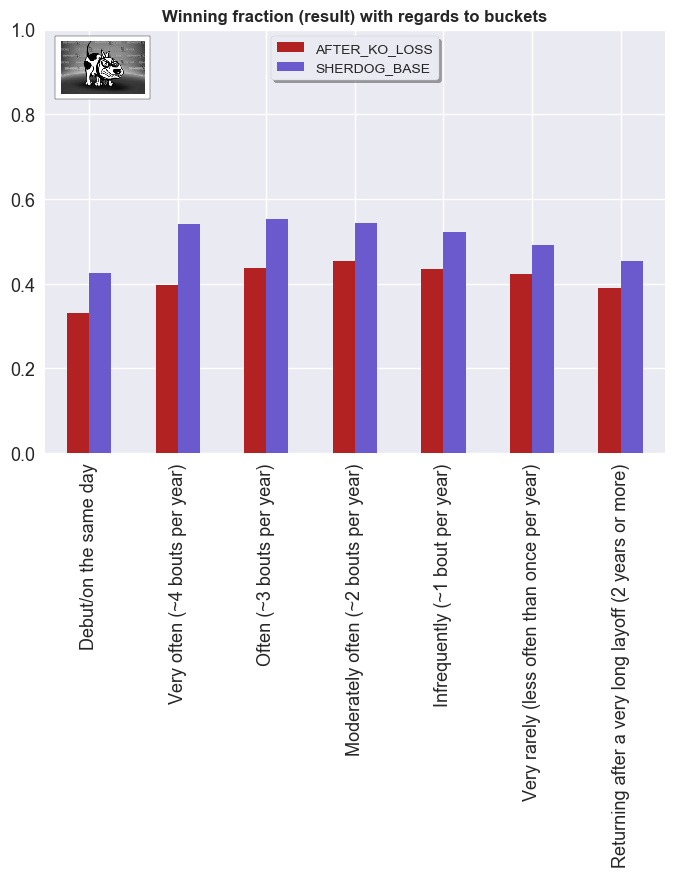

In [727]:
create_occ_barplot(sherdog_ako_frame, 'sherdog', ['firebrick', 'slateblue'])

The result of the Sherdog database analysis in regards to bouts where a fighter came back after a KO/TKO loss looks very interesting. **First of all, there is a strong negative correlation between returning after a KO/TKO loss and having a chance of winning.** This relation can be observed for each single bucket which also makes sense from an intuitive standpoint - we tend to decrease the fighter's chances of winning in the next fight if he/she previously lost by knockout.

**Secondly, by looking into each interval, we can observe that the disparity in results increases with the rise of frequency represented by buckets.**
If a fighter decides to take a fight within 90 days of his/her last KO/TKO loss, his/her chances are approximately *14 percentage points* lower than they would be if there was no leading KO/TKO loss. On the other hand, if a fighter decides to wait more or less one year his/her chances are a bit less than *10 percentage points lower*. Finally, if a layoff takes longer than one year his/her chances of winning are lowered by *7 percentage points*.

**The tendency described above confirms that the hypothesis is definitely present, although the percentage differences have not reached the level which was established at the beginning of the analysis as statistically significant.** As we can see, a fighter who has decided to wait up to over two years increased his/her chances of winning by *7 percentage points* (the base level was a *14 percentage point* difference with the frequency interval described as very often and there is a *7 percentage point* difference for the category labeled as - Returning after a very long layoff).

Now it is time to check if having a 5-round fight (independently from the result) has any impact on how long a fighter should wait before taking the next bout in regards to his/her chances of getting a positive result (win) in his/her next fight.

In [728]:
ufc_extra_data[0:10]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval,Method,Round
0,Shamil Abdurakhimov,loss,UFC 242 - Khabib vs. Poirier,2019-09-07,140,Moderately often (~2 bouts per year),TKO (Elbow and Punch),2
1,Shamil Abdurakhimov,win,UFC Fight Night 149 - Overeem vs. Oleynik,2019-04-20,217,Infrequently (~1 bout per year),TKO (Punches),2
2,Shamil Abdurakhimov,win,UFC Fight Night 136 - Hunt vs. Oleynik,2018-09-15,294,Infrequently (~1 bout per year),Decision (Unanimous),3
3,Shamil Abdurakhimov,win,UFC Fight Night 122 - Bisping vs. Gastelum,2017-11-25,351,Infrequently (~1 bout per year),KO (Punches),1
4,Shamil Abdurakhimov,loss,UFC Fight Night 102 - Lewis vs. Abdurakhimov,2016-12-09,69,Very often (~4 bouts per year),TKO (Punches),4
5,Shamil Abdurakhimov,win,UFC Fight Night 96 - Lineker vs. Dodson,2016-10-01,223,Infrequently (~1 bout per year),Decision (Split),3
6,Shamil Abdurakhimov,win,UFC Fight Night 83 - Cerrone vs. Oliveira,2016-02-21,323,Infrequently (~1 bout per year),Decision (Unanimous),3
7,Shamil Abdurakhimov,loss,UFC Fight Night 63 - Mendes vs. Lamas,2015-04-04,301,Infrequently (~1 bout per year),TKO (Punches),1
8,Shamil Abdurakhimov,win,M-1 Challenge 49 - Battle in the Mountains,2014-06-07,246,Infrequently (~1 bout per year),Decision (Unanimous),3
9,Shamil Abdurakhimov,win,Tech-Krep FC - Southern Front 2,2013-10-04,551,Very rarely (less often than once per year),Decision (Unanimous),3


In [729]:
# Applying mask in order to filter through records that are meeting the new analysis constraints. 
# Assigning outcome to a variable.
ufc_after_5r = ufc_extra_data[(ufc_extra_data['Round'].shift(-1) == 5) & 
                              (ufc_extra_data['Fighter'] == ufc_extra_data['Fighter'].shift(-1))].copy()

In [730]:
ufc_after_5r[0:20]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval,Method,Round
51,Israel Adesanya,win,UFC 243 - Whittaker vs. Adesanya,2019-10-05,175,Moderately often (~2 bouts per year),KO (Punches),2
54,Israel Adesanya,win,UFC 230 - Cormier vs. Lewis,2018-11-03,120,Often (~3 bouts per year),TKO (Knees and Punches),1
73,Kevin Aguilar,win,LFA 40 - Aguilar vs. Le,2018-05-25,294,Infrequently (~1 bout per year),KO (Punches),1
75,Kevin Aguilar,win,LFA 4 - Aguilar vs. Jackson,2017-02-17,231,Infrequently (~1 bout per year),KO (Punches),3
218,Jose Aldo,loss,UFC 212 - Aldo vs. Holloway,2017-06-03,329,Infrequently (~1 bout per year),TKO (Punches),3
220,Jose Aldo,loss,UFC 194 - Aldo vs. McGregor,2015-12-12,413,Very rarely (less often than once per year),KO (Punch),1
221,Jose Aldo,win,UFC 179 - Aldo vs. Mendes 2,2014-10-25,266,Infrequently (~1 bout per year),Decision (Unanimous),5
223,Jose Aldo,win,UFC 163 - Aldo vs. Korean Zombie,2013-08-03,182,Moderately often (~2 bouts per year),TKO (Punches),4
225,Jose Aldo,win,UFC 142 - Aldo vs. Mendes,2012-01-14,98,Often (~3 bouts per year),KO (Knee),1
226,Jose Aldo,win,UFC 136 - Edgar vs. Maynard 3,2011-10-08,161,Moderately often (~2 bouts per year),Decision (Unanimous),5


In [731]:
len(ufc_after_5r)

395

In [732]:
# Assigning the 'Descriptive_interval' column to a variable.
ufc_5r_brackets = ufc_after_5r['Descriptive_interval']

In [733]:
# Creating variables where interval data is assigned based on the type of fights' outcome.
ufc_5r_all_fights_count = ufc_5r_brackets.value_counts()
ufc_5r_win_fights_count = ufc_5r_brackets[ufc_after_5r['Result'] == 'win'].value_counts()
ufc_5r_loss_fights_count = ufc_5r_brackets[ufc_after_5r['Result'] == 'loss'].value_counts()
ufc_5r_draw_fights_count = ufc_5r_brackets[ufc_after_5r['Result'] == 'draw'].value_counts()
ufc_5r_nc_fights_count = ufc_5r_brackets[ufc_after_5r['Result'] == 'NC'].value_counts()

In [734]:
ufc_5r_all_fights_count

Moderately often (~2 bouts per year)                    140
Infrequently (~1 bout per year)                         131
Often (~3 bouts per year)                                48
Very often (~4 bouts per year)                           40
Very rarely (less often than once per year)              33
Returning after a very long layoff (2 years or more)      3
Debut/on the same day                                     0
Name: Descriptive_interval, dtype: int64

In [735]:
# Checking if there are any missing values in the 'Descriptive_interval' column.
ufc_after_5r[ufc_after_5r['Descriptive_interval'].isna()]

,Fighter,Result,Event,Event_date,Time_interval,Descriptive_interval,Method,Round


In [736]:
# Data validation - checking if there is any record that was not qualified as either win, loss, draw or no-contest.
ufc_5r_sum_of_brackets = (ufc_5r_win_fights_count.sum() + ufc_5r_loss_fights_count.sum() + ufc_5r_draw_fights_count.sum() 
                          + ufc_5r_nc_fights_count.sum())

if ufc_5r_all_fights_count.sum() == ufc_5r_sum_of_brackets:
    print('Verification successful!')

Verification successful!


In [737]:
# Assigning result (percentage ratio between amount of wins and total amount of wins and losses) to a variable.
ufc_5r_pct = ufc_5r_win_fights_count/(ufc_5r_win_fights_count + ufc_5r_loss_fights_count)

In [738]:
# Sorting results in ascending order.
ufc_5r_sorted = ufc_5r_pct.sort_values(ascending=False)

In [739]:
# Dropping debut category due to the lack of observations.
ufc_5r_sorted = ufc_5r_sorted.drop(labels=['Debut/on the same day'])

In [740]:
ufc_5r_sorted

Very often (~4 bouts per year)                          0.825000
Moderately often (~2 bouts per year)                    0.737226
Infrequently (~1 bout per year)                         0.726562
Returning after a very long layoff (2 years or more)    0.666667
Often (~3 bouts per year)                               0.645833
Very rarely (less often than once per year)             0.468750
Name: Descriptive_interval, dtype: float64

In [741]:
ufc_pct_trunc

Returning after a very long layoff (2 years or more)    0.830357
Very often (~4 bouts per year)                          0.800858
Often (~3 bouts per year)                               0.742574
Moderately often (~2 bouts per year)                    0.734148
Infrequently (~1 bout per year)                         0.722242
Very rarely (less often than once per year)             0.703540
Name: Descriptive_interval, dtype: float64

In [742]:
# Creating new data frame.
ufc_5r_frame = pd.DataFrame(dict(AFTER_5R_FIGHT = ufc_5r_sorted, UFC_ROSTER = ufc_pct_trunc))

In [743]:
# Reindexing data frames in order to get neat visualization.
rep3_index = ['Very often (~4 bouts per year)', 'Often (~3 bouts per year)', 
             'Moderately often (~2 bouts per year)', 'Infrequently (~1 bout per year)',
             'Very rarely (less often than once per year)', 'Returning after a very long layoff (2 years or more)']

ufc_5r_frame = ufc_5r_frame.reindex(index=rep3_index)

In [744]:
ufc_5r_frame

,AFTER_5R_FIGHT,UFC_ROSTER
Very often (~4 bouts per year),0.825000,0.800858
Often (~3 bouts per year),0.645833,0.742574
Moderately often (~2 bouts per year),0.737226,0.734148
Infrequently (~1 bout per year),0.726562,0.722242
Very rarely (less often than once per year),0.468750,0.703540
Returning after a very long layoff (2 years or more),0.666667,0.830357


<Figure size 1800x900 with 0 Axes>

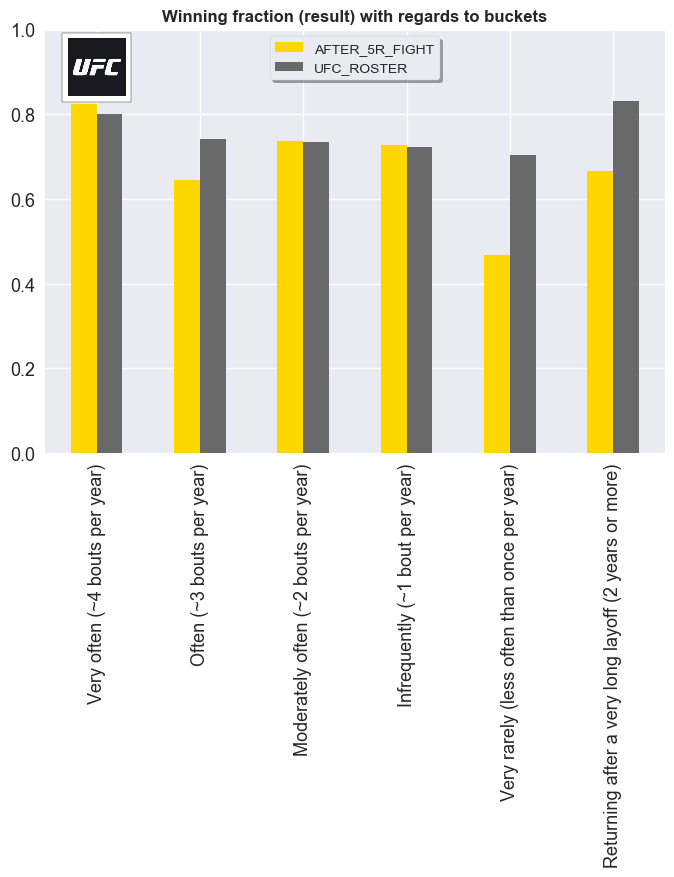

In [745]:
create_occ_barplot(ufc_5r_frame, 'ufc', ['gold','dimgrey'])

The UFC roster analysis has not revealed any correlations between the result and the fact that a fighter's previous bout was a 5 round fight. It is worth mentioning that the number of observations was quite low - below 100, only two buckets representing frequency of 1 and 2 bouts per year exceeded 100 observations. As we can see on the chart, especially these two buckets have not revealed any correlations.

Lets look at the Sherdog database from the same angle.

In [746]:
sherdog_extra_data[0:10]

,Fighter,Result,Event_date,Time_interval,Descriptive_interval,Method,Round
0,Tony Galindo,loss,2005-03-20,758,Returning after a very long layoff (2 years or...,KO (Punches),1
1,Tony Galindo,loss,2003-02-21,530,Very rarely (less often than once per year),TKO (Corner Stoppage),1
2,Tony Galindo,loss,2001-09-09,78,Very often (~4 bouts per year),TKO (Corner Stoppage),2
3,Tony Galindo,win,2001-06-23,119,Often (~3 bouts per year),Decision,2
4,Tony Galindo,draw,2001-02-24,87,Very often (~4 bouts per year),Draw,2
5,Tony Galindo,win,2000-11-29,158,Moderately often (~2 bouts per year),TKO (Punches),1
6,Tony Galindo,win,2000-06-24,0,Debut/on the same day,KO (Punch),1
7,Kurt Rojo,loss,2000-12-09,168,Moderately often (~2 bouts per year),Decision,3
8,Kurt Rojo,loss,2000-06-24,0,Debut/on the same day,KO (Punch),1
9,Brian Hawkins,loss,2006-03-18,1121,Returning after a very long layoff (2 years or...,Submission (Heel Hook),1


In [747]:
# Applying mask in order to filter through records that are meeting the new analysis constraints.
sherdog_after_5r = sherdog_extra_data[(sherdog_extra_data['Round'].shift(-1) == 5) & 
                              (sherdog_extra_data['Fighter'] == sherdog_extra_data['Fighter'].shift(-1))].copy()

In [748]:
sherdog_after_5r[0:10]

,Fighter,Result,Event_date,Time_interval,Descriptive_interval,Method,Round
214,Ricco Rodriguez,loss,2003-02-28,154,Moderately often (~2 bouts per year),TKO (Punches),1
753,Dan Severn,win,2004-11-20,69,Very often (~4 bouts per year),TKO (Punches),2
963,Joe Stevenson,win,2016-07-30,547,Very rarely (less often than once per year),TKO (Punches),1
1239,Travis Fulton,win,2006-12-15,28,Very often (~4 bouts per year),TKO (Submission to Slam),3
2016,Gary Goodridge,win,2002-06-23,174,Moderately often (~2 bouts per year),Decision (Split),3
2318,Tito Ortiz,loss,2004-04-02,189,Infrequently (~1 bout per year),KO (Punches),2
2320,Tito Ortiz,win,2002-11-22,420,Very rarely (less often than once per year),TKO (Corner Stoppage),3
2324,Tito Ortiz,win,2000-12-16,246,Infrequently (~1 bout per year),Submission (Neck Crank),1
2362,Kevin Randleman,loss,2000-11-17,161,Moderately often (~2 bouts per year),TKO (Strikes),3
2363,Kevin Randleman,win,2000-06-09,203,Infrequently (~1 bout per year),Decision (Unanimous),5


In [749]:
len(sherdog_after_5r)

3152

In [750]:
# Assigning the 'Descriptive_interval' column to variable.
sherdog_5r_brackets = sherdog_after_5r['Descriptive_interval']

In [751]:
# Creating variables where interval data is assigned based on the type of fights' outcome.
sherdog_5r_all_fights_count = sherdog_5r_brackets.value_counts()
sherdog_5r_win_fights_count = sherdog_5r_brackets[sherdog_after_5r['Result'] == 'win'].value_counts()
sherdog_5r_loss_fights_count = sherdog_5r_brackets[sherdog_after_5r['Result'] == 'loss'].value_counts()
sherdog_5r_draw_fights_count = sherdog_5r_brackets[sherdog_after_5r['Result'] == 'draw'].value_counts()
sherdog_5r_nc_fights_count = sherdog_5r_brackets[sherdog_after_5r['Result'] == 'NC'].value_counts()

In [752]:
sherdog_5r_all_fights_count

Infrequently (~1 bout per year)                         888
Moderately often (~2 bouts per year)                    777
Very often (~4 bouts per year)                          679
Often (~3 bouts per year)                               418
Very rarely (less often than once per year)             296
Returning after a very long layoff (2 years or more)     84
Debut/on the same day                                    10
Name: Descriptive_interval, dtype: int64

In [753]:
# Checking if there are any missing values in 'Descriptive_interval' column.
sherdog_after_5r[sherdog_after_5r['Descriptive_interval'].isna()]

,Fighter,Result,Event_date,Time_interval,Descriptive_interval,Method,Round


In [754]:
# Data validation - checking if there is any record that was not qualified as either win, loss, draw or no-contest.
sherdog_5r_sum_of_brackets = (sherdog_5r_win_fights_count.sum() + sherdog_5r_loss_fights_count.sum() + 
sherdog_5r_draw_fights_count.sum() + sherdog_5r_nc_fights_count.sum())

if sherdog_5r_all_fights_count.sum() == sherdog_5r_sum_of_brackets:
    print('Verification successful!')

Verification successful!


In [755]:
# Assigning result (percentage ratio between amount of wins and total amount of wins and losses) to variable.
sherdog_5r_pct = sherdog_5r_win_fights_count/(sherdog_5r_win_fights_count + sherdog_5r_loss_fights_count)

In [756]:
# Sorting results in ascending order.
sherdog_5r_sorted = sherdog_5r_pct.sort_values(ascending=False)

In [757]:
sherdog_5r_sorted

Moderately often (~2 bouts per year)                    0.641830
Often (~3 bouts per year)                               0.627451
Very often (~4 bouts per year)                          0.614114
Infrequently (~1 bout per year)                         0.599307
Very rarely (less often than once per year)             0.547368
Returning after a very long layoff (2 years or more)    0.481481
Debut/on the same day                                   0.400000
Name: Descriptive_interval, dtype: float64

In [758]:
sherdog_pct_sorted

Often (~3 bouts per year)                               0.553287
Moderately often (~2 bouts per year)                    0.542192
Very often (~4 bouts per year)                          0.539734
Infrequently (~1 bout per year)                         0.521535
Very rarely (less often than once per year)             0.490557
Returning after a very long layoff (2 years or more)    0.454122
Debut/on the same day                                   0.424212
Name: Descriptive_interval, dtype: float64

In [759]:
# Creating a new data frame.
sherdog_5r_frame = pd.DataFrame(dict(AFTER_5R_FIGHT = sherdog_5r_sorted, SHERDOG_BASE = sherdog_pct_sorted))

In [760]:
# Reindexing data frames in order to get clearer visualization.
rep4_index = ['Debut/on the same day', 'Very often (~4 bouts per year)', 'Often (~3 bouts per year)', 
             'Moderately often (~2 bouts per year)', 'Infrequently (~1 bout per year)',
             'Very rarely (less often than once per year)', 'Returning after a very long layoff (2 years or more)']

sherdog_5r_frame = sherdog_5r_frame.reindex(index=rep4_index)

In [761]:
sherdog_5r_frame

,AFTER_5R_FIGHT,SHERDOG_BASE
Debut/on the same day,0.400000,0.424212
Very often (~4 bouts per year),0.614114,0.539734
Often (~3 bouts per year),0.627451,0.553287
Moderately often (~2 bouts per year),0.641830,0.542192
Infrequently (~1 bout per year),0.599307,0.521535
Very rarely (less often than once per year),0.547368,0.490557
Returning after a very long layoff (2 years or more),0.481481,0.454122


<Figure size 1800x900 with 0 Axes>

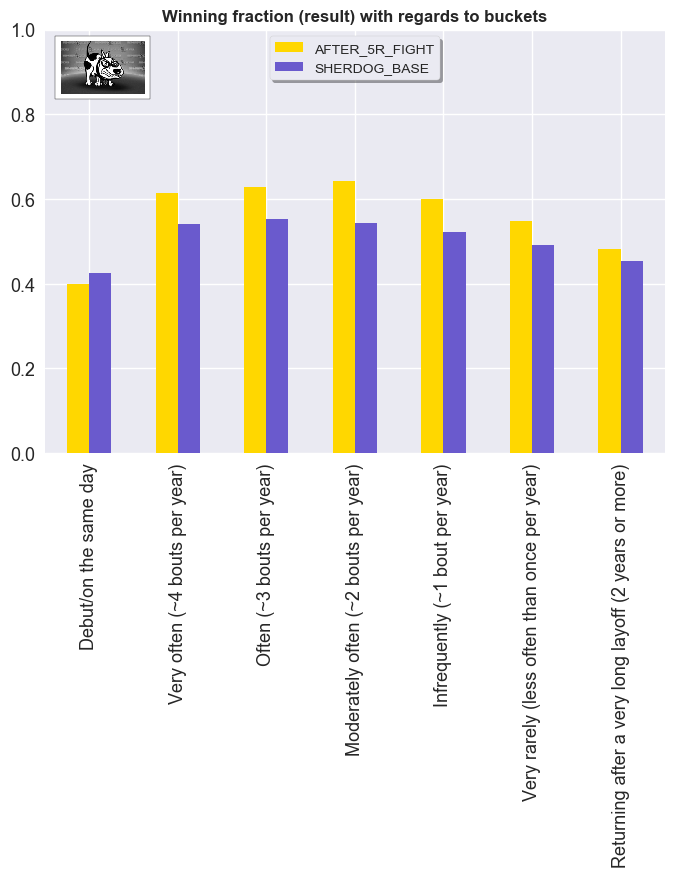

In [762]:
create_occ_barplot(sherdog_5r_frame, 'sherdog', ['gold', 'slateblue'])

The Sherdog's database results are quite interesting - there a is minor positive correlation between fighting a 5 round bout and scoring a positive result (win) in the next fight. It is hard to explain why this is the case, although there is definitely no reliance on time intervals. 

## Segment 6: *Summary, conclusions and interesting side facts*

**The Analysis revealed that there is a statistically significant relationship between taking a fight within 91 - 182 days since the last bout and returning after a break longer than 2 years in regards to the results based on the data collected for all fighters.** A fighter that comes back after a 91 to 182 day break will have a *10 percentage point* higher chance of getting a positive result (win) on average. The foregoing reliance was not confirmed for the population of the entire UFC roster.

An evident distinction between the results for Sherdog's database and the UFC roster (regardless of time intervals) was observed. The UFC roster had on average a **20-30 percentage point higher result** for each bucket.

**A fighting frequency of 1 or 2 fights per year predominates in the UFC** - there were the highest amount of observations for these two categories.

**The analysis demonstrated that there is basically no difference between fighting with frequency of 1, 2 or 3 times per year in the UFC in regards to the result.** Moreover, there was a noticable (not to a degree where it becomes statistically significant) negative impact on the result connected with the interval describing the highest frequency of 4 bouts per year and the one which is related to a lower frequency than 1 bout per year. Both of these buckets have scored **6-7 percentage point** lower results.

The analysis showed that fighting less often than once per year but more often than once per 2 years is disadvantageous for the UFC fighters as well as for the UFC roster fighting exclusively in the UFC.

When it comes to the gender breakdown, we have observed that women in the UFC score higher results in buckets representing lower frequencies (1-2 bouts per year). The time interval between **121 and 365 days** looks like the optimal time between fights in regards to the results. It has to be noticed that we have observed surprisingly high results for men and women who returned after a very long layoff (over 2 years). That was especially the case for women where the result for this bucket was relevantly higher.
Based on that, we can speculate that there is no such thing as "ring rust" or that fighters that return after a very long break are matched with relatively low-skilled opponents. That would imply that the UFC is basically using a tune up fight mechanism. We cannot disreagrd that both of these things are true and that they do coexist.

Lets look at some very specific dependencies characteristic for weight classes in the UFC:

* In the light-heavyweight division high frequency is an advantage in regards to the results. Buckets which represent the frequency of 4 bouts per year scored a 14 percentage point higher result than the interval connected to the frequency of 1 bout per year.

* In the middleweight division the worst outcome was scored by two fringe buckets - 4 bouts per year and less often than once per year. Both of these buckets scored a 10 percentage point lower result than the interval representing the frequency of 2 bouts per year.

* In the lightweight and the featherweight divisions we have observed that the lower the frequency is the better the results are.

* The men's bantamweight bucket representing a very low frequency (less often than once per year) scored a 30% percentage point lower result than the other buckets.

* The women's strawweight bucket representing a very low frequency scored the highest result, being approximately 10 percentage points ahead.

* The women's flyweight division bucket representing the time interval of 1 bout per year scored the highest result (over 10 percentage points higher than the other buckets).

* In the women's bantamweight division the highest result was obtained by two intervals - one representing a frequency of 1 bout per year and the second representing a frequency of 2 bouts per year. Both buckets scored a 15 percentage point higher result than the rest.

Let's see what was revealed by the analysis which took special circumstances into account:

* There is a strong negative correlation between returning after a KO/TKO loss and the probability of winning the next fight based on the Sherdog's database analysis.

* We have observed an upward trend in probability of getting positive a result (win) for fighters in Sherdog's database who came back after a KO/TKO loss along with extended time between fights. Despite the fact that the tendency was flawless, the differences were not high enough to classify them as statistically significant.

* We have observed a statistically significant positive correlation for Sherdog's database between the probability of getting a positive result (win) and returning after a 5 round fight. Despite that fact, we have not observed any differences in regards to time intervals.

* In contrast to all fighters in Sherdog's database, there was **no noticable correlation** between returning after a KO/TKO loss and the probability of winning the next fight for fighters that are a part of the UFC roster.

* In contrast to all fighters in Sherdog's database, there was **no noticable correlation** between returning after a 5 round fight and the probability of winning the next fight for fighters that are a part of the UFC roster.

Finally, we have observed that **over 80% of fighters in the current UFC roster won their MMA debut.**

The longest layoff in the history of professional MMA can be attributed to *Mikhail Onufrienko*. His layoff took **8730 days** which is roughly **24 years!**. Our record-holder took a loss via KO in his brave return. Frankly, it is quite unbelievable that someone decided to return after such a long time... unless this is just a dreadful blunder by Sherdog.

In [763]:
sherdog_selected_data.loc[sherdog_selected_data['Time_interval'].idxmax()]

Fighter                                                Mikhail Onufrienko
Result                                                               loss
Event_date                                            2019-09-08 00:00:00
Time_interval                                                        8730
Descriptive_interval    Returning after a very long layoff (2 years or...
Name: 222877, dtype: object